In [40]:
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import matplotlib as mpl

In [42]:
def w(L,C):
    w = 1.0 / np.sqrt(L*C)
    return w / (2*np.pi)

def C_from_L_fr(L, fr, ToPrint=True):
    '''
    L in Henry
    fr in Hz
    return C in Farads
    '''
    C = 1.0 /( L * (2*np.pi*fr)**2 )
    if ToPrint:
        print( 'L is:', round( 1e9*L, 3 ), '[nH];  fr is:', round( 1e-9*fr, 3 ), '[GHz];  C is:', round( 1e15*C, 2 ), '[fF]')
    return C

def get_Cs(Lj, fr_q):
    L_q = L_j / 2
    C_q = C_from_L_fr( L_q, fr_q )
    C_s = C_q / 2
    return C_s

########################

In [43]:
## new good function ##
def process_HFSS_frLC(filename, datlim=[None,None], title=''):
    '''
    To extract the Capsitance from simple LC oscillator (one mode, one L)
    Takes file with shape [L, fr], fit the data and returns C=const
    use datlim to crop the data
    '''
    data = np.loadtxt(filename)
    
    L_list = 1e-9*data[:,0]  ## in H
    fr_list = data[:,1]      ##in Hz
    x_data = L_list[ datlim[0]:datlim[1] ]
    y_data = fr_list[ datlim[0]:datlim[1] ]
    
    from scipy import optimize
    def freqLC(L, L_prst, C):
        L_tot = L + np.abs(L_prst)
        w = 1.0 / np.sqrt( L_tot*C )
        return w / (2*np.pi)
    init_L_prst = 0
    init_C = 50e-15
    init_params = [init_L_prst, init_C]
    params, params_covariance = optimize.curve_fit(freqLC, x_data, y_data, p0=init_params)

    [L_prst,C] = params 
    C_str = 'C = '+ str(round(1e15*C,3))+ ' [fF]'
    L_str = 'Lprst = '+ str(round(1e9*L_prst,3))+ ' [nH]'
    title_string = title+'\n'+C_str+'\n'+L_str
    print(C_str)
    print(L_str)

    ##
    fig, ax = plt.subplots()
    ax.plot(1e9*x_data, 1e-9*y_data, 'o', label='HFSS')
    ax.plot(1e9*x_data, 1e-9*freqLC(x_data, L_prst, C), '--', label='fit=(1/2pi) * ( 1/SQRT( C*(L+Lprst) ) )')

    ax.legend()
    ax.grid()
    ax.set_title(title_string)
    ax.set_xlabel('L [nH]')
    ax.set_ylabel('Freq [GHz]')

    return C

# Two eigenmodes, La,Lj (full system) -> Cs,Ct

In [44]:
def get_Cs_Ct_from_fQ_fA(fr_a, fr_q, L_a, L_j):
    def get_Cs_from_frQ_FulSys(fr_q, L_j):
        w_q = fr_q * 2*np.pi
        C_s = 1.0/( L_j*w_q**2 )
        return C_s
    C_s = get_Cs_from_frQ_FulSys( fr_q, L_j )
    w_a = fr_a * 2*np.pi
    L = (L_j*L_a) / (2*L_j+L_a) ##shouldbe_correct
#     L = L_a / (1. + (0.5*L_a/L_j) )  ##wrong
    C_t = 1./(L * w_a**2) - 0.5*C_s
    return [C_s, C_t]

## article example ##
print('Article Example:')
[C_s, C_t] = get_Cs_Ct_from_fQ_fA(7.78e9, 6.284e9, 5.32e-9, 5.597e-9)
print('C_s=',C_s*1e15, 'fF')
print('C_t=',C_t*1e15, 'fF')

Article Example:
('C_s=', 114.60738508130959, 'fF')
('C_t=', 174.7916418824165, 'fF')


In [45]:
def print_C_from_file(filename):
    '''
    Takes file of data this shape:
    L_j [nH]	L_a [nH]	fr1 [Hz]	fr2 [Hz]
    and print all data + Cs and Ct
    '''
    data = np.loadtxt(filename)

    L_j_list = 1e-9*data[:,0] 
    L_a_list = 1e-9*data[:,1]
    fr_q_list = data[:,2]
    fr_a_list = data[:,3]
    
    Cs_list = []
    Ct_list = []
    for i in range(len( L_a_list )):
        [C_s, C_t] = get_Cs_Ct_from_fQ_fA(fr_a_list[i], fr_q_list[i], L_a_list[i], L_j_list[i])
        Cs_list.append(C_s)
        Ct_list.append(C_t)
        
    print(' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA')
    for i in range(len( L_j_list )):
        print( 1e9*L_j_list[i], 1e9*L_a_list[i],' ', round(1e15*Cs_list[i]), round(1e15*Ct_list[i]),' ', round(1e-9*fr_q_list[i],2),'', round(1e-9*fr_a_list[i],2) )


In [46]:
### data processing ###
class HFSS_Result_Circular:
    La = 0
    Lj = 0
    
    R1 = 0
    Gap = 0
    RingWidth = 0
    SectorAngle = 0
    
    R2 = 0
    R3 = 0
    PerimeterCs = 0
    AreaSideCt = 0
    
    
    fr_q = 0
    fr_a = 0
    
    Cs = 0
    Ct = 0
    
    
    def __init__(self, R1, Gap, RingWidth, SectorAngle, fr_q, fr_a, La=40e-9, Lj = 60e-9):
        self.La  = La
        self.Lj  = Lj
        self.fr_a = fr_a
        self.fr_q = fr_q
        
        self.R1  = R1
        self.Gap = Gap
        self.RingWidth = RingWidth
        self.SectorAngle = SectorAngle
        
        self.R2 = R1 + Gap
        self.R3 = self.R2 + RingWidth
        self.PerimeterCs  = 2 *np.pi *(self.R2 - R1) /Gap
        self.AreaSideCt = 0.5*SectorAngle  * np.pi *( self.R3**2 - self.R2**2 ) /( 2*self.R2 +RingWidth )

        [self.Cs, self.Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, self.La, self.Lj)
    



In [48]:
C_s_target_coef = 1.0
C_t_target_coef = 1.5

C_s = 105
C_t = 64

C_s_target = C_s * C_s_target_coef
C_t_target = C_t * C_t_target_coef
print('C_s_target: ', C_s_target)
print('C_t_target: ', C_t_target)
print('___________')
C_s_target = 110.0
C_t_target = 92.0
print('C_s_target: ', C_s_target)
print('C_t_target: ', C_t_target)
print('Cs/Ct_target: ', C_s_target / C_t_target)

('C_s_target: ', 105.0)
('C_t_target: ', 96.0)
___________
('C_s_target: ', 110.0)
('C_t_target: ', 92.0)
('Cs/Ct_target: ', 1.1956521739130435)


In [49]:
R_article_Cs = 110
R_hfss_Cs    = 105
R_article_Ct = 59
R_hfss_Ct    = 64
A = 1.062
B = 1.486

print( "Cs wanted",  round(min(A*R_article_Cs, A*R_hfss_Cs)), round(max(A*R_article_Cs, A*R_hfss_Cs)) )
print( "Ct wanted",  round(min(B*R_article_Ct, B*R_hfss_Ct)), round(max(B*R_article_Ct, B*R_hfss_Ct)) )

print('\n')
print("Cs wanted", 112)
print("Ct wanted", 95)
print("Cs/Ct wanted", 112.0/95.0)

('Cs wanted', 112.0, 117.0)
('Ct wanted', 88.0, 95.0)


('Cs wanted', 112)
('Ct wanted', 95)
('Cs/Ct wanted', 1.1789473684210525)


#### plotter of all results 

In [50]:
def plot_CsCt_scatter_R1(list_circ_res, fig=None, ax=None, target=[112, 95], figsize=[16,16], fontsize=10, color='red', marker='x', xlim=[None, None], ylim=[None, None]):
    """ 
    Plot in a scatterplot the embeddings of the words specified in the list "words".
    Include a label next to each point.
    """
    if fig is None and ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)        
        ax.set_title('HFSS   CircularGeo   label=( R1 [um], Gap [um], RingWidth [um], Angle [%] )')
        ax.axvline(target[0], color='gold', alpha=0.3)
        ax.axhline(target[1], color='gold', alpha=0.3)
        ax.set_xlabel('Cs [fF]')
        ax.set_ylabel('Ct [fF]')
        ax.grid(alpha=0.2)
        ax.axis('equal')
        
    for i in list_circ_res:
        x, y = round(1e15*i.Cs), round(1e15*i.Ct)
        word = str(i.R1) +' ' +str(i.Gap) +' ' +str(i.RingWidth) +' ' +str(round(i.SectorAngle, 2)) 
        ax.scatter(x, y, marker=marker, color=color)
        ax.text(x+.03, y+.03, word, fontsize=fontsize)
        
    
    return [fig, ax]

In [51]:
def plot_CsCt_scatter_R3(list_circ_res, fig=None, ax=None, target=[112, 95], figsize=[16,16], fontsize=10, color='red', marker='x', xlim=[None, None], ylim=[None, None]):
    """ 
    Plot in a scatterplot the embeddings of the words specified in the list "words".
    Include a label next to each point.
    """
    if fig is None and ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)        
        ax.set_title('HFSS   CircularGeo   label=( R3 [um], Gap [um], RingWidth [um], Angle [%] )')
        ax.axvline(target[0], color='gold', alpha=0.3)
        ax.axhline(target[1], color='gold', alpha=0.3)
        ax.set_xlabel('Cs [fF]')
        ax.set_ylabel('Ct [fF]')
        ax.grid(alpha=0.2)
        ax.axis('equal')
        
    for i in list_circ_res:
        x, y = round(1e15*i.Cs), round(1e15*i.Ct)
        word = str(i.R3) +' ' +str(i.Gap) +' ' +str(i.RingWidth) +' ' +str(round(i.SectorAngle, 2)) 
        ax.scatter(x, y, marker=marker, color=color)
        ax.text(x+.03, y+.03, word, fontsize=fontsize)
        
    
    return [fig, ax]

# Plot what we have (prepare data first)

#### R1, Gap, RingWidth, Theta

In [52]:
fig = None
ax = None
xlim = [None, None]
ylim = [None, None]

### Circular geo

In [53]:
list_circ_res = []
def print_string(R1, Gap, Width, Theta, La, Lj, fr_q, fr_a):
    [Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
    print('|'+ "{:5.0f}".format(R1) +' |'+ "{:5.0f}".format(Gap) +' |'+ "{:5.0f}".format(Width) +' | '+ "{:2.3f}".format(Theta) +' ||'+ "{:6.1f}".format(1e15*Cs) +' |'+ "{:6.1f}".format(1e15*Ct)+' |'+"{:5.2f}".format(Cs/Ct)+' |' ) 
    s = HFSS_Result_Circular(R1,Gap,Width,Theta, fr_q, fr_a)
    list_circ_res.append(s)
    
def print_string_R3(R3, Gap, Width, Theta, La, Lj, fr_q, fr_a):
    [Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
    print('|'+ "{:5.0f}".format(R3) +' |'+ "{:5.0f}".format(Gap) +' |'+ "{:5.0f}".format(Width) +' | '+ "{:2.3f}".format(Theta) +' ||'+ "{:6.1f}".format(1e15*Cs) +' |'+ "{:6.1f}".format(1e15*Ct)+' |'+"{:5.2f}".format(Cs/Ct)+' |' ) 
    R1 = R3 - Gap - Width
    s = HFSS_Result_Circular(R1,Gap,Width,Theta, fr_q, fr_a)
    list_circ_res.append(s)
#     build_matrix( R3, Gap, Width, Theta, Cs, Ct )

### 17 Jun Circular Geometry 

### All the CircularGeo Data is here (wires = 1 um)

### process data and save again

In [54]:
## check file
folder = 'D:\\Data\\=Exp_Data=\\Results\\HFSS_results\\1_CircularGeo_DB\\'
filename = '20200617_Circular database_R3_EXTENDED_noComas'
data = np.loadtxt(folder+filename+'.txt')
data[0]

array([  5.00000000e-01,   1.60000000e+02,   5.00000000e+01,
         5.00000000e+01,   2.62946155e+09,   4.16153019e+09])

In [55]:
def process_and_save(folder, filename):
#     data_format_string = 'R3, Gap, Width, SectorAngle, fr_q, fr_a'
    data = np.loadtxt(folder+filename+'.txt')
    ## add Cs Ct to the array
    La, Lj = 40e-9, 60e-9

    N_strings = len(data)
    M_values = len(data[0])
    print( 'N: '+ str(N_strings) )
    print( 'M: '+ str(M_values) )
    data_processed = np.zeros((N_strings, M_values+2))

    for i in range(len(data)):
        datstr = data[i]
        R3, Gap, Width, SectorAngle, fr_q, fr_a  = datstr[0], datstr[1], datstr[2], datstr[3],  datstr[4], datstr[5]
        [Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
        data_processed[i] = [R3*1e3, Gap, Width, SectorAngle, fr_q*1e-9, fr_a*1e-9, Cs*1e15, Ct*1e15]
        ## [um], [um], [um], [%], [GHz], [GHz], [fF], [fF]

    header_string = 'Circular Geometry HFSS (17 Jun 2020) \n La = 40 [nH] Lj = 60 [nH] \n R3 [um], Gap [um], RingWidth [um], SectorAngle [%], fr1[GHz], fr2[GHz], Cs[nH], Ct[nH]'
    np.savetxt(folder+filename+'Done.txt', data_processed, header=header_string)
    print('done')
    return 


#################################################
folder = 'D:\\Data\\=Exp_Data=\\Results\\HFSS_results\\CircularGeo_DB\\'
filename = '20200617_Circular database_R3_EXTENDED_noComas'
##
##
##
# process_and_save(folder, filename)  ## be carefull when switch it ON
##
##
##

____________

# Work on


### Circular with assimetric shift 520

In [57]:
def add_point(x, y, text='', ax=ax, fontsize=8, marker='x', color='k'):
    ax.scatter(x, y, marker=marker, color=color)
    ax.text(x+.1, y+.1, text, fontsize=fontsize)
    
def print_string_R3_assim(R3, Gap, Width, Theta, ThetaStruc, La, Lj, fr_q, fr_a, PLOT=True, color='k', marker='x'):
    [Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
    print('|'+ "{:5.0f}".format(R3) +' |'+ "{:5.0f}".format(Gap) +' |'+ "{:5.0f}".format(Width) +' | '+ "{:2.3f}".format(Theta)+' | '+ "{:2.3f}".format(ThetaStruc) +' ||'+ "{:6.1f}".format(1e15*Cs) +' |'+ "{:6.1f}".format(1e15*Ct)+' |'+"{:5.2f}".format(Cs/Ct)+' |' ) 
    R1 = R3 - Gap - Width
    s = HFSS_Result_Circular(R1,Gap,Width,Theta, fr_q, fr_a)
    list_circ_res.append(s)
#     if PLOT:
#         add_point(1e15*Cs, 1e15*Ct, text=str(R3)+', '+str(Gap)+', '+str(Width)+', '+str(Theta)+', '+str(ThetaStruc), color=color, marker=marker)


print('|----------------------------------------------------|')
print( '\n=======06/07/2020========================================================\n')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta |StAng_c||  Cs   |   Ct  | Cs/Ct|')
print('Wires 8um repeat decided parameters more precise 0.001% freq')
                ## |  R3  |  Gap | Width| Theta |StAng_c|     
print_string_R3_assim(710,   140,    70,   0.75,  1.0,   40e-9, 60e-9, 1.83513e9, 3.01704e9)
print_string_R3_assim(710,   140,    70,   0.75,  1.0,   40e-9, 60e-9, 1.85129e9, 3.04124e9)

|----------------------------------------------------|

=======06/07/2020========================================================

|----------------------------------------------------|
|  R3  |  Gap | Width| Theta |StAng_c||  Cs   |   Ct  | Cs/Ct|
Wires 8um repeat decided parameters more precise 0.001% freq
|  710 |  140 |   70 | 0.750 | 1.000 || 125.4 | 122.8 | 1.02 |
|  710 |  140 |   70 | 0.750 | 1.000 || 123.2 | 121.0 | 1.02 |


|----------------------------------------------------|

=======03/07/2020========================================================

|----------------------------------------------------|
|  R3  |  Gap | Width| Theta |StAng_c||  Cs   |   Ct  | Cs/Ct|
Wires 8um
Substrate thikness 0.28 mm
|  650 |  120 |   60 | 0.750 | 1.000 || 118.2 | 110.6 | 1.07 |
Substrate thikness 0.3 mm
|  650 |  120 |   60 | 0.750 | 1.000 || 119.2 | 111.7 | 1.07 |
|  700 |  120 |   60 | 0.750 | 1.000 || 131.3 | 118.0 | 1.11 |
|  700 |  140 |   80 | 0.750 | 1.000 || 123.1 | 126.1 | 0.98 |
|  650 |  140 |   60 | 0.750 | 1.000 || 111.1 | 111.0 | 1.00 |
|  700 |  140 |   60 | 0.750 | 1.000 || 122.4 | 116.6 | 1.05 |
|  750 |  140 |   60 | 0.750 | 1.000 || 133.7 | 122.8 | 1.09 |
|  720 |  140 |   60 | 0.750 | 1.000 || 127.0 | 119.2 | 1.07 |
|  720 |  150 |   60 | 0.750 | 1.000 || 123.1 | 118.9 | 1.04 |
|  720 |  140 |   70 | 0.750 | 1.000 || 127.6 | 124.1 | 1.03 |
|  700 |  140 |   70 | 0.750 | 1.000 || 123.0 | 121.5 | 1.

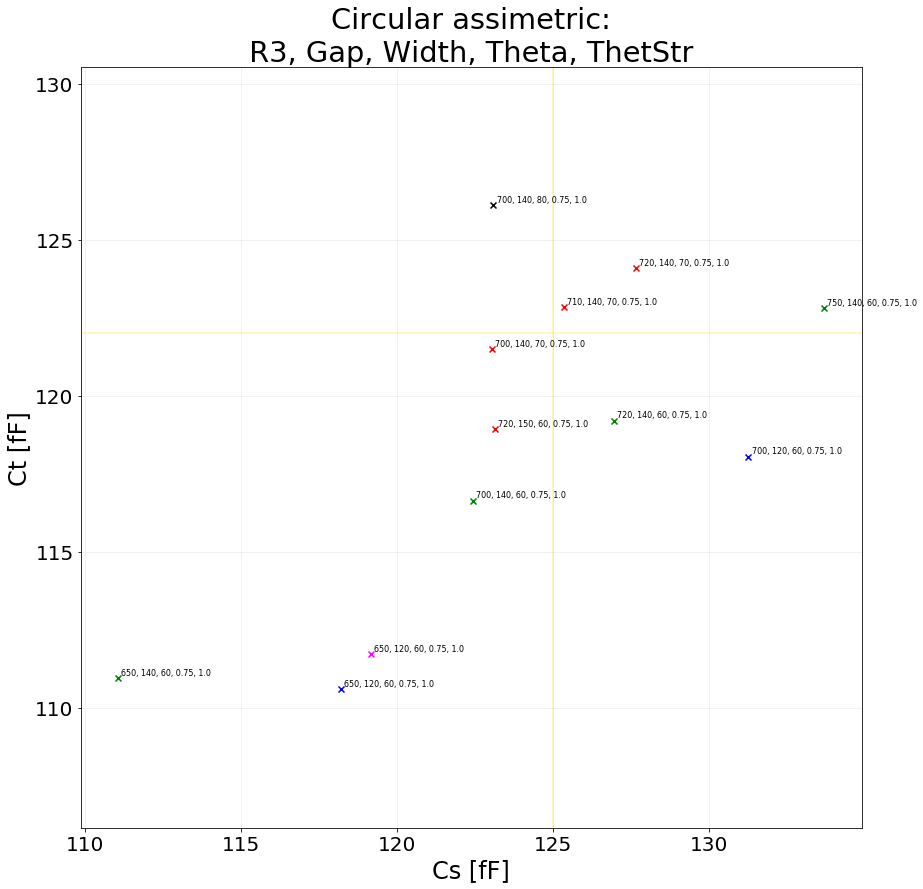

In [58]:
target=[125, 122]
fig = plt.figure(figsize=[14,14])
ax = fig.add_subplot(1, 1, 1)        
ax.set_title('Circular assimetric:\n R3, Gap, Width, Theta, ThetStr ')
ax.axvline(target[0], color='gold', alpha=0.3)
ax.axhline(target[1], color='gold', alpha=0.3)
ax.set_xlabel('Cs [fF]')
ax.set_ylabel('Ct [fF]')
ax.grid(alpha=0.2)
ax.axis('equal')

def add_point(x, y, text='', ax=ax, fontsize=8, marker='x', color='k'):
    ax.scatter(x, y, marker=marker, color=color)
    ax.text(x+.1, y+.1, text, fontsize=fontsize)
    
def print_string_R3_assim(R3, Gap, Width, Theta, ThetaStruc, La, Lj, fr_q, fr_a, PLOT=True, color='k', marker='x'):
    [Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
    print('|'+ "{:5.0f}".format(R3) +' |'+ "{:5.0f}".format(Gap) +' |'+ "{:5.0f}".format(Width) +' | '+ "{:2.3f}".format(Theta)+' | '+ "{:2.3f}".format(ThetaStruc) +' ||'+ "{:6.1f}".format(1e15*Cs) +' |'+ "{:6.1f}".format(1e15*Ct)+' |'+"{:5.2f}".format(Cs/Ct)+' |' ) 
    R1 = R3 - Gap - Width
    s = HFSS_Result_Circular(R1,Gap,Width,Theta, fr_q, fr_a)
    list_circ_res.append(s)
    if PLOT:
        add_point(1e15*Cs, 1e15*Ct, text=str(R3)+', '+str(Gap)+', '+str(Width)+', '+str(Theta)+', '+str(ThetaStruc), color=color, marker=marker)


print('|----------------------------------------------------|')
print( '\n=======03/07/2020========================================================\n')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta |StAng_c||  Cs   |   Ct  | Cs/Ct|')
print('Wires 8um')
                ## |  R3  |  Gap | Width| Theta |StAng_c|
print('Substrate thikness 0.28 mm')
print_string_R3_assim(650,   120,    60,   0.75,  1.0,   40e-9, 60e-9, 1.88977e9, 3.15447e9, color='b')
print('Substrate thikness 0.3 mm')
print_string_R3_assim(650,   120,    60,   0.75,  1.0,   40e-9, 60e-9, 1.88213e9, 3.13963e9, color='magenta')
print_string_R3_assim(700,   120,    60,   0.75,  1.0,   40e-9, 60e-9, 1.79342e9, 3.03212e9, color='b')
print_string_R3_assim(700,   140,    80,   0.75,  1.0,   40e-9, 60e-9, 1.85196e9, 2.99982e9, color='k')
print_string_R3_assim(650,   140,    60,   0.75,  1.0,   40e-9, 60e-9, 1.94965e9, 3.18482e9, color='g')
print_string_R3_assim(700,   140,    60,   0.75,  1.0,   40e-9, 60e-9, 1.85689e9, 3.08130e9, color='g')
print_string_R3_assim(750,   140,    60,   0.75,  1.0,   40e-9, 60e-9, 1.77721e9, 2.98415e9, color='g')
print_string_R3_assim(720,   140,    60,   0.75,  1.0,   40e-9, 60e-9, 1.82357e9, 3.04040e9, color='g')
print_string_R3_assim(720,   150,    60,   0.75,  1.0,   40e-9, 60e-9, 1.85169e9, 3.05876e9, color='r')
print_string_R3_assim(720,   140,    70,   0.75,  1.0,   40e-9, 60e-9, 1.81859e9, 2.99767e9, color='r')
print_string_R3_assim(700,   140,    70,   0.75,  1.0,   40e-9, 60e-9, 1.85240e9, 3.03766e9, color='r')
print_string_R3_assim(710,   140,    70,   0.75,  1.0,   40e-9, 60e-9, 1.83513e9, 3.01704e9, color='r')

|----------------------------------------------------|

=======30/06/2020========================================================

|----------------------------------------------------|
|  R3  |  Gap | Width| Theta |StAng_c||  Cs   |   Ct  | Cs/Ct|
Wires 8um
|  700 |  200 |   50 | 0.800 | 1.000 || 104.4 | 116.5 | 0.90 |
|  700 |  200 |   50 | 0.750 | 1.000 || 102.3 | 110.8 | 0.92 |
|  700 |  200 |   50 | 0.700 | 0.700 ||  97.5 | 101.3 | 0.96 |

=======02/07/2020========================================================

|  700 |  200 |   50 | 0.700 | 1.000 ||  99.9 | 105.7 | 0.95 |
|  750 |  200 |   50 | 0.700 | 0.700 || 107.3 | 106.5 | 1.01 |
|  750 |  180 |   50 | 0.700 | 0.700 || 112.5 | 106.2 | 1.06 |
|  750 |  180 |   50 | 0.700 | 0.800 || 113.8 | 107.8 | 1.05 |
|  750 |  200 |   80 | 0.750 | 1.000 || 101.6 | 125.4 | 0.81 |
|  750 |  180 |   80 | 0.750 | 1.000 || 107.9 | 125.1 | 0.86 |
|  750 |  180 |   70 | 0.750 | 1.000 || 108.2 | 120.7 | 0.90 |
|  750 |  180 |   60 | 0.750 | 1.00

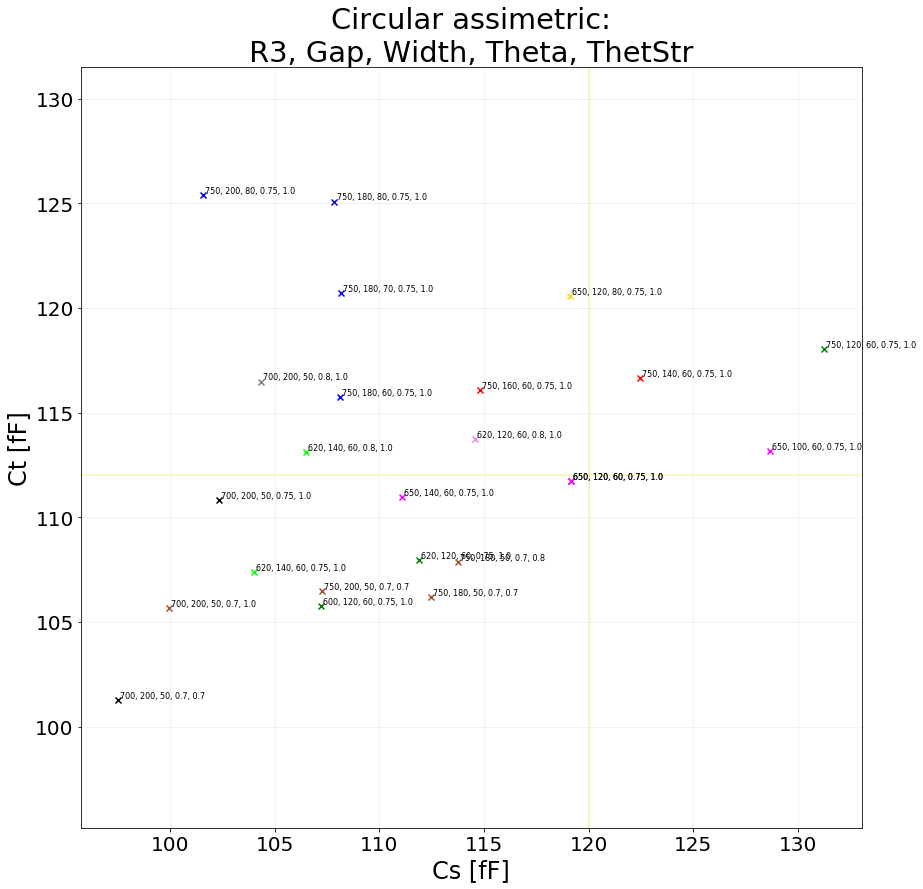

In [59]:
target=[120, 112]
fig = plt.figure(figsize=[14,14])
ax = fig.add_subplot(1, 1, 1)        
ax.set_title('Circular assimetric:\n R3, Gap, Width, Theta, ThetStr ')
ax.axvline(target[0], color='gold', alpha=0.3)
ax.axhline(target[1], color='gold', alpha=0.3)
ax.set_xlabel('Cs [fF]')
ax.set_ylabel('Ct [fF]')
ax.grid(alpha=0.2)
ax.axis('equal')

def add_point(x, y, text='', ax=ax, fontsize=8, marker='x', color='k'):
    ax.scatter(x, y, marker=marker, color=color)
    ax.text(x+.1, y+.1, text, fontsize=fontsize)
    
def print_string_R3_assim(R3, Gap, Width, Theta, ThetaStruc, La, Lj, fr_q, fr_a, PLOT=True, color='k', marker='x'):
    [Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
    print('|'+ "{:5.0f}".format(R3) +' |'+ "{:5.0f}".format(Gap) +' |'+ "{:5.0f}".format(Width) +' | '+ "{:2.3f}".format(Theta)+' | '+ "{:2.3f}".format(ThetaStruc) +' ||'+ "{:6.1f}".format(1e15*Cs) +' |'+ "{:6.1f}".format(1e15*Ct)+' |'+"{:5.2f}".format(Cs/Ct)+' |' ) 
    R1 = R3 - Gap - Width
    s = HFSS_Result_Circular(R1,Gap,Width,Theta, fr_q, fr_a)
    list_circ_res.append(s)
    if PLOT:
        add_point(1e15*Cs, 1e15*Ct, text=str(R3)+', '+str(Gap)+', '+str(Width)+', '+str(Theta)+', '+str(ThetaStruc), color=color, marker=marker)


print('|----------------------------------------------------|')
print( '\n=======30/06/2020========================================================\n')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta |StAng_c||  Cs   |   Ct  | Cs/Ct|')
print('Wires 8um')
                ## |  R3  |  Gap | Width| Theta |StAng_c|
print_string_R3_assim(700,   200,    50,   0.8,   1.0,   40e-9, 60e-9, 2.01132e9, 3.16427e9, color='grey') 
print_string_R3_assim(700,   200,    50,   0.75,  1.0,   40e-9, 60e-9, 2.03130e9, 3.22900e9, color='k') 
print_string_R3_assim(700,   200,    50,   0.7,   0.7,   40e-9, 60e-9, 2.08086e9, 3.35521e9, color='k') 

print( '\n=======02/07/2020========================================================\n')
print_string_R3_assim(700,   200,    50,   0.7,   1.0,   40e-9, 60e-9, 2.05533e9, 3.29404e9, color='sienna') 
print_string_R3_assim(750,   200,    50,   0.7,   0.7,   40e-9, 60e-9, 1.98377e9, 3.24772e9, color='sienna') 
print_string_R3_assim(750,   180,    50,   0.7,   0.7,   40e-9, 60e-9, 1.93759e9, 3.22445e9, color='sienna') 
print_string_R3_assim(750,   180,    50,   0.7,   0.8,   40e-9, 60e-9, 1.92642e9, 3.20187e9, color='sienna') 
print_string_R3_assim(750,   200,    80,   0.75,  1.0,   40e-9, 60e-9, 2.03892e9, 3.09609e9, color='b')  #field is perfect
print_string_R3_assim(750,   180,    80,   0.75,  1.0,   40e-9, 60e-9, 1.97844e9, 3.07141e9, color='b') 
print_string_R3_assim(750,   180,    70,   0.75,  1.0,   40e-9, 60e-9, 1.97546e9, 3.10821e9, color='b') 
print_string_R3_assim(750,   180,    60,   0.75,  1.0,   40e-9, 60e-9, 1.97621e9, 3.15371e9, color='b') 
print_string_R3_assim(750,   160,    60,   0.75,  1.0,   40e-9, 60e-9, 1.91773e9, 3.11995e9, color='r') 
print_string_R3_assim(750,   140,    60,   0.75,  1.0,   40e-9, 60e-9, 1.85689e9, 3.08130e9, color='r') 
print_string_R3_assim(750,   120,    60,   0.75,  1.0,   40e-9, 60e-9, 1.79342e9, 3.03212e9, color='g') 
# print_string_R3_assim(750,   100,    60,   0.75,  1.0,   40e-9, 60e-9, 1.72957e9, 2.97879e9, color='r') 
# print_string_R3_assim(750,    80,    60,   0.75,  1.0,   40e-9, 60e-9, 1.66216e9, 2.91680e9, color='r') 
print_string_R3_assim(650,   120,    60,   0.75,  1.0,   40e-9, 60e-9, 1.88213e9, 3.13963e9, color='magenta') 
print_string_R3_assim(600,   120,    60,   0.75,  1.0,   40e-9, 60e-9, 1.98448e9, 3.25545e9, color='g') 
print_string_R3_assim(620,   120,    60,   0.75,  1.0,   40e-9, 60e-9, 1.94244e9, 3.20990e9, color='g') 
print_string_R3_assim(620,   120,    60,   0.80,  1.0,   40e-9, 60e-9, 1.91977e9, 3.14230e9, color='violet') 
print_string_R3_assim(620,   140,    60,   0.80,  1.0,   40e-9, 60e-9, 1.99123e9, 3.18603e9, color='lime') 
print_string_R3_assim(620,   140,    60,   0.75,  1.0,   40e-9, 60e-9, 2.01457e9, 3.25496e9, color='lime') 

print_string_R3_assim(650,   140,    60,   0.75,  1.0,   40e-9, 60e-9, 1.94965e9, 3.18482e9, color='magenta') 
print_string_R3_assim(650,   100,    60,   0.75,  1.0,   40e-9, 60e-9, 1.81127e9, 3.08429e9, color='magenta') 
print_string_R3_assim(650,   120,    80,   0.75,  1.0,   40e-9, 60e-9, 1.88281e9, 3.06202e9, color='gold') 
print('|----------------------------------------------------|')
print('best (new target):')
print_string_R3_assim(650,   120,    60,   0.75,  1.0,   40e-9, 60e-9, 1.88213e9, 3.13963e9, color='magenta')


=======29/06/2020========================================================

_____Precise_model_15passes_0.03%error_____
|----------------------------------------------------|
|  R3  |  Gap | Width| Theta |StAng_c||  Cs   |   Ct  | Cs/Ct|
Wires 8um
|  850 |  200 |   50 | 0.500 | 1.000 || 115.2 | 101.6 | 1.13 |
|  850 |  200 |   50 | 0.700 | 0.600 || 124.3 | 115.0 | 1.08 |
|  850 |  240 |   50 | 0.700 | 0.600 || 113.5 | 114.3 | 0.99 |
|----------------------------------------------------|

=======30/06/2020========================================================

|----------------------------------------------------|
|  R3  |  Gap | Width| Theta |StAng_c||  Cs   |   Ct  | Cs/Ct|
Wires 8um
|  850 |  240 |   80 | 0.700 | 1.000 || 118.7 | 134.3 | 0.88 |
|  800 |  240 |   80 | 0.700 | 1.000 || 108.9 | 129.2 | 0.84 |
|  800 |  240 |   80 | 0.500 | 0.500 ||  90.7 |  94.6 | 0.96 |
|  800 |  240 |   80 | 0.800 | 1.000 || 112.7 | 143.6 | 0.79 |
|  800 |  200 |   80 | 0.800 | 1.000 || 125.6 | 143.

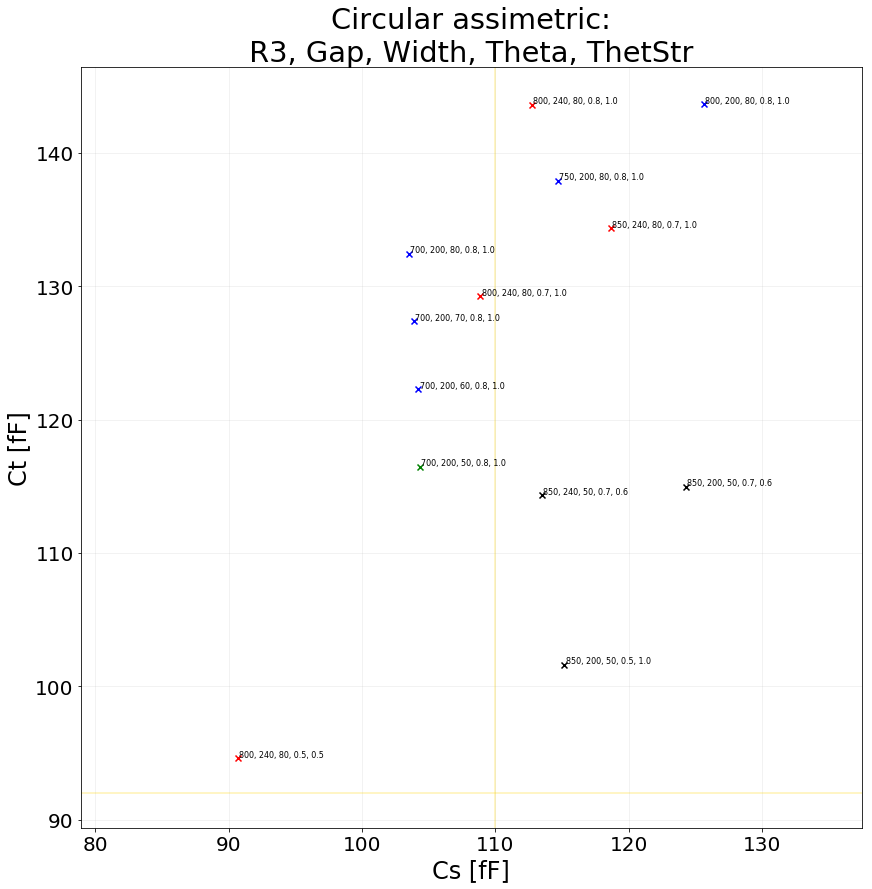

In [60]:
target=[110, 92]
fig = plt.figure(figsize=[14,14])
ax = fig.add_subplot(1, 1, 1)        
ax.set_title('Circular assimetric:\n R3, Gap, Width, Theta, ThetStr ')
ax.axvline(target[0], color='gold', alpha=0.3)
ax.axhline(target[1], color='gold', alpha=0.3)
ax.set_xlabel('Cs [fF]')
ax.set_ylabel('Ct [fF]')
ax.grid(alpha=0.2)
ax.axis('equal')

def add_point(x, y, text='', ax=ax, fontsize=8, marker='x', color='k'):
    ax.scatter(x, y, marker=marker, color=color)
    ax.text(x+.1, y+.1, text, fontsize=fontsize)
    
def print_string_R3_assim(R3, Gap, Width, Theta, ThetaStruc, La, Lj, fr_q, fr_a, PLOT=True, color='k', marker='x'):
    [Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
    print('|'+ "{:5.0f}".format(R3) +' |'+ "{:5.0f}".format(Gap) +' |'+ "{:5.0f}".format(Width) +' | '+ "{:2.3f}".format(Theta)+' | '+ "{:2.3f}".format(ThetaStruc) +' ||'+ "{:6.1f}".format(1e15*Cs) +' |'+ "{:6.1f}".format(1e15*Ct)+' |'+"{:5.2f}".format(Cs/Ct)+' |' ) 
    R1 = R3 - Gap - Width
    s = HFSS_Result_Circular(R1,Gap,Width,Theta, fr_q, fr_a)
    list_circ_res.append(s)
    if PLOT:
        add_point(1e15*Cs, 1e15*Ct, text=str(R3)+', '+str(Gap)+', '+str(Width)+', '+str(Theta)+', '+str(ThetaStruc), color=color, marker=marker)

##############################################################################################
print( '\n=======29/06/2020========================================================\n')
print('_____Precise_model_15passes_0.03%error_____')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta |StAng_c||  Cs   |   Ct  | Cs/Ct|')
print('Wires 8um')
print_string_R3_assim(850,   200,  50,   0.50,  1.0,   40e-9, 60e-9, 1.91469e9, 3.25682e9)
print_string_R3_assim(850,   200,  50,   0.7,   0.6,   40e-9, 60e-9, 1.84308e9, 3.08799e9)
print_string_R3_assim(850,   240,  50,   0.7,   0.6,   40e-9, 60e-9, 1.92871e9, 3.14168e9)
print('|----------------------------------------------------|')

print( '\n=======30/06/2020========================================================\n')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta |StAng_c||  Cs   |   Ct  | Cs/Ct|')
print('Wires 8um')
                ## |  R3  |  Gap | Width| Theta |StAng_c|
print_string_R3_assim(850,   240,    80,   0.7,   1.0,   40e-9, 60e-9, 1.88629e9, 2.95297e9, color='r')
print_string_R3_assim(800,   240,    80,   0.7,   1.0,   40e-9, 60e-9, 1.96918e9, 3.03220e9, color='r')
print_string_R3_assim(800,   240,    80,   0.5,   0.5,   40e-9, 60e-9, 2.15768e9, 3.47359e9, color='r')
print_string_R3_assim(800,   240,    80,   0.8,   1.0,   40e-9, 60e-9, 1.93505e9, 2.90602e9, color='r')
print_string_R3_assim(800,   200,    80,   0.8,   1.0,   40e-9, 60e-9, 1.83312e9, 2.86003e9, color='b')
print_string_R3_assim(750,   200,    80,   0.8,   1.0,   40e-9, 60e-9, 1.91885e9, 2.94106e9, color='b')
print_string_R3_assim(700,   200,    80,   0.8,   1.0,   40e-9, 60e-9, 2.01950e9, 3.02780e9, color='b')
print_string_R3_assim(700,   200,    70,   0.8,   1.0,   40e-9, 60e-9, 2.01572e9, 3.06868e9, color='b')
print_string_R3_assim(700,   200,    60,   0.8,   1.0,   40e-9, 60e-9, 2.01252e9, 3.11187e9, color='b')
print_string_R3_assim(700,   200,    50,   0.8,   1.0,   40e-9, 60e-9, 2.01132e9, 3.16427e9, color='g') 



In [61]:
130.0 / 59.6

2.1812080536912752


=======29/06/2020========================================================

_____Precise_model_30passes_0.03%error_____
|----------------------------------------------------|
|  R3  |  Gap | Width| Theta |StAng_c||  Cs   |   Ct  | Cs/Ct|
Wires 1um
|  850 |  200 |   50 | 0.700 | 0.082 || 122.0 | 113.5 | 1.07 |
|  850 |  220 |   50 | 0.700 | 0.082 || 116.5 | 113.0 | 1.03 |
Wires 4um
|  850 |  220 |   50 | 0.700 | 0.082 || 118.5 | 113.9 | 1.04 |
Wires 8um
|  850 |  220 |   50 | 0.700 | 0.082 || 119.0 | 114.9 | 1.04 |
Wires 4um
|  850 |  220 |   50 | 0.650 | 0.082 || 113.5 | 107.1 | 1.06 |
|  850 |  220 |  100 | 0.650 | 0.082 || 115.8 | 127.3 | 0.91 |
|  900 |  220 |  100 | 0.650 | 0.082 || 124.8 | 132.0 | 0.95 |
|  950 |  220 |  100 | 0.650 | 0.082 || 133.7 | 136.9 | 0.98 |
|  800 |  220 |  100 | 0.650 | 0.082 || 106.3 | 122.5 | 0.87 |
|  800 |  220 |   80 | 0.650 | 0.082 || 106.5 | 115.0 | 0.93 |
|  800 |  220 |   60 | 0.650 | 0.082 || 105.5 | 106.9 | 0.99 |
|  800 |  220 |   40 | 0.650 

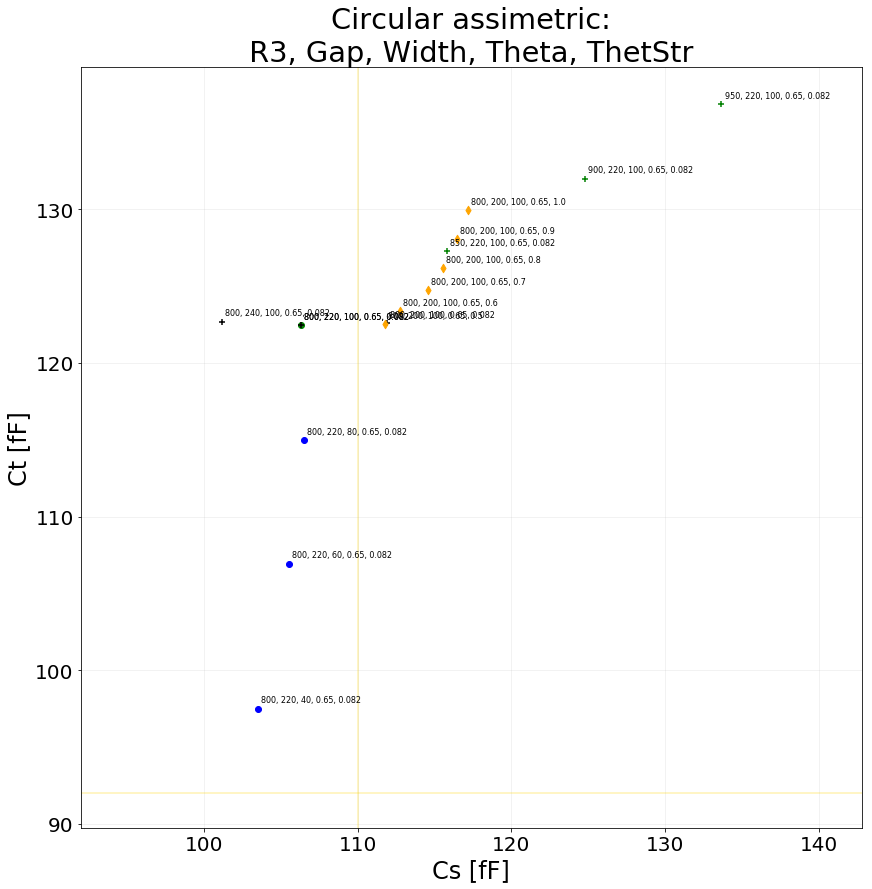

In [62]:
target=[110, 92]
fig = plt.figure(figsize=[14,14])
ax = fig.add_subplot(1, 1, 1)        
ax.set_title('Circular assimetric:\n R3, Gap, Width, Theta, ThetStr ')
ax.axvline(target[0], color='gold', alpha=0.3)
ax.axhline(target[1], color='gold', alpha=0.3)
ax.set_xlabel('Cs [fF]')
ax.set_ylabel('Ct [fF]')
ax.grid(alpha=0.2)
ax.axis('equal')

def add_point(x, y, text='', ax=ax, fontsize=8, marker='x', color='k'):
    ax.scatter(x, y, marker=marker, color=color)
    ax.text(x+.2, y+.4, text, fontsize=fontsize)
    
def print_string_R3_assim(R3, Gap, Width, Theta, ThetaStruc, La, Lj, fr_q, fr_a, PLOT=True, color='k', marker='x'):
    [Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
    print('|'+ "{:5.0f}".format(R3) +' |'+ "{:5.0f}".format(Gap) +' |'+ "{:5.0f}".format(Width) +' | '+ "{:2.3f}".format(Theta)+' | '+ "{:2.3f}".format(ThetaStruc) +' ||'+ "{:6.1f}".format(1e15*Cs) +' |'+ "{:6.1f}".format(1e15*Ct)+' |'+"{:5.2f}".format(Cs/Ct)+' |' ) 
    R1 = R3 - Gap - Width
    s = HFSS_Result_Circular(R1,Gap,Width,Theta, fr_q, fr_a)
    list_circ_res.append(s)
    if PLOT:
        add_point(1e15*Cs, 1e15*Ct, text=str(R3)+', '+str(Gap)+', '+str(Width)+', '+str(Theta)+', '+str(ThetaStruc), color=color, marker=marker)

#############################################################################################

print( '\n=======29/06/2020========================================================\n')
print('_____Precise_model_30passes_0.03%error_____')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta |StAng_c||  Cs   |   Ct  | Cs/Ct|')
print('Wires 1um')
                # '|  R3  |  Gap | Width| Theta |ThetStr||'
print_string_R3_assim(850,   200,   50,   0.7,   0.082,    40e-9, 60e-9, 1.86028e9, 3.11101e9, PLOT=False)
print_string_R3_assim(850,   220,   50,   0.7,   0.082,    40e-9, 60e-9, 1.90382e9, 3.14069e9, PLOT=False)
print('Wires 4um')
print_string_R3_assim(850,   220,   50,   0.7,   0.082,    40e-9, 60e-9, 1.88761e9, 3.12257e9, PLOT=False)
print('Wires 8um')
print_string_R3_assim(850,   220,   50,   0.7,   0.082,    40e-9, 60e-9, 1.88328e9, 3.11195e9, PLOT=False)
print('Wires 4um')
print_string_R3_assim(850,   220,   50,   0.65,  0.082,    40e-9, 60e-9, 1.92880e9, 3.21088e9, PLOT=False)

## vary R3
print_string_R3_assim(850,   220,  100,   0.65,  0.082,    40e-9, 60e-9, 1.90958e9, 3.01973e9, color='g', marker='+')
print_string_R3_assim(900,   220,  100,   0.65,  0.082,    40e-9, 60e-9, 1.83921e9, 2.94725e9, color='g', marker='+')
print_string_R3_assim(950,   220,  100,   0.65,  0.082,    40e-9, 60e-9, 1.77718e9, 2.87931e9, color='g', marker='+')
print_string_R3_assim(800,   220,  100,   0.65,  0.082,    40e-9, 60e-9, 1.99283e9, 3.10073e9, color='g', marker='o')
## vary Width
print_string_R3_assim(800,   220,  80,   0.65,  0.082,    40e-9, 60e-9, 1.99112e9, 3.16851e9, color='b', marker='o')
print_string_R3_assim(800,   220,  60,   0.65,  0.082,    40e-9, 60e-9, 2.00014e9, 3.25167e9, color='b', marker='o')
print_string_R3_assim(800,   220,  40,   0.65,  0.082,    40e-9, 60e-9, 2.01989e9, 3.36385e9, color='b', marker='o')

## vary Gap
print_string_R3_assim(800,   240, 100,   0.65,  0.082,    40e-9, 60e-9, 2.04279e9, 3.12173e9, color='k', marker='+')
print_string_R3_assim(800,   220, 100,   0.65,  0.082,    40e-9, 60e-9, 1.99283e9, 3.10073e9, color='k', marker='+') ##copy
print_string_R3_assim(800,   200, 100,   0.65,  0.082,    40e-9, 60e-9, 1.94235e9, 3.07543e9, color='k', marker='+')

## vary StrAngle_coef (0 - 1)
print_string_R3_assim(800,   200, 100,   0.65,  0.5,    40e-9, 60e-9, 1.94379e9, 3.07669e9, color='orange', marker='d')
print_string_R3_assim(800,   200, 100,   0.65,  0.6,    40e-9, 60e-9, 1.93524e9, 3.06527e9, color='orange', marker='d')
print_string_R3_assim(800,   200, 100,   0.65,  0.7,    40e-9, 60e-9, 1.91979e9, 3.04595e9, color='orange', marker='d')
print_string_R3_assim(800,   200, 100,   0.65,  0.8,    40e-9, 60e-9, 1.91145e9, 3.02977e9, color='orange', marker='d')
print_string_R3_assim(800,   200, 100,   0.65,  0.9,    40e-9, 60e-9, 1.90386e9, 3.01065e9, color='orange', marker='d')
print_string_R3_assim(800,   200, 100,   0.65,  1.0,    40e-9, 60e-9, 1.89821e9, 2.99279e9, color='orange', marker='d')

print('|------------------------------------------------------------|')



### Circular 501

### Repeat precise measurement

In [63]:
print( '\n=======17/06/2020========================================================\n')
print('Wires 1um')
print('_____Precise_model_30passes_0.03%error_____')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
list_circ_res = []
print_string_R3(850, 200,   50,   0.50,   40e-9, 60e-9, 1.98046e9, 3.38456e9)


=======17/06/2020========================================================

Wires 1um
_____Precise_model_30passes_0.03%error_____
|----------------------------------------------------|
|  R3  |  Gap | Width| Theta ||  Cs   |   Ct  | Cs/Ct|
|  850 |  200 |   50 | 0.500 || 107.6 |  93.6 | 1.15 |


### 16 Jun Circular Geometry 

In [64]:
### time ###
speed = 2.0 #min/solution
n = 4. # number of points

# points = n**4
# points = 4 * 3 * 3 * 4
points = 144

total_time_min = points *speed
total_time_hours =  total_time_min / 60.0
total_time_days = total_time_hours / 24.0
print total_time_min, 'min'
print total_time_hours, 'hours'
print total_time_days, 'days'

288.0 min
4.8 hours
0.2 days



=======16/06/2020========================================================

Wires 1um
___vary R3_____
|----------------------------------------------------|
|  R3  |  Gap | Width| Theta ||  Cs   |   Ct  | Cs/Ct|
|  600 |  200 |   70 | 0.650 ||  75.8 |  98.1 | 0.77 |
|  650 |  200 |   70 | 0.650 ||  85.7 | 102.4 | 0.84 |
|  700 |  200 |   70 | 0.650 ||  95.6 | 106.8 | 0.89 |
|  750 |  200 |   70 | 0.650 || 105.1 | 111.8 | 0.94 |
|  800 |  200 |   70 | 0.650 || 114.3 | 116.4 | 0.98 |
|  850 |  200 |   70 | 0.650 || 123.4 | 121.0 | 1.02 |
|  900 |  200 |   70 | 0.650 || 132.9 | 126.5 | 1.05 |
|  950 |  200 |   70 | 0.650 || 142.0 | 132.4 | 1.07 |
| 1000 |  200 |   70 | 0.650 || 150.8 | 137.9 | 1.09 |

___vary Width_____
|----------------------------------------------------|
|  R3  |  Gap | Width| Theta ||  Cs   |   Ct  | Cs/Ct|
|  750 |  200 |   50 | 0.650 || 103.8 | 102.8 | 1.01 |
|  750 |  200 |   60 | 0.650 || 104.8 | 107.6 | 0.97 |
|  750 |  200 |   70 | 0.650 || 105.1 | 111.8 | 0.94 

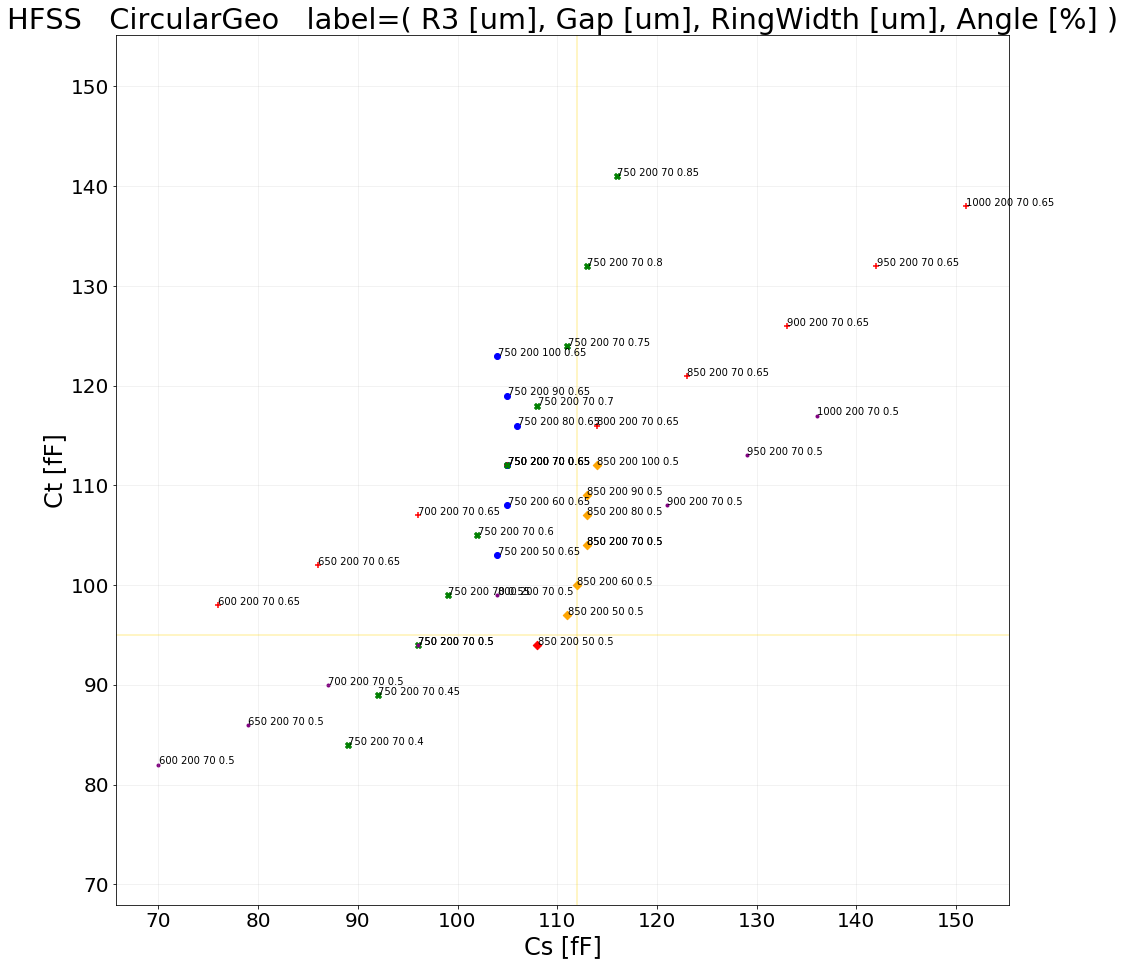

In [65]:
print( '\n=======16/06/2020========================================================\n')
print('Wires 1um')

print('___vary R3_____')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
list_circ_res = []
print_string_R3(600, 200,    70,   0.65,    40e-9, 60e-9, 2.35936e9, 3.52318e9)
print_string_R3(650, 200,    70,   0.65,    40e-9, 60e-9, 2.21889e9, 3.40937e9)
print_string_R3(700, 200,    70,   0.65,    40e-9, 60e-9, 2.10180e9, 3.30486e9)
print_string_R3(750, 200,    70,   0.65,    40e-9, 60e-9, 2.00427e9, 3.20565e9)
print_string_R3(800, 200,    70,   0.65,    40e-9, 60e-9, 1.92175e9, 3.11927e9)
print_string_R3(850, 200,    70,   0.65,    40e-9, 60e-9, 1.84969e9, 3.04013e9)
print_string_R3(900, 200,    70,   0.65,    40e-9, 60e-9, 1.78259e9, 2.95869e9)
print_string_R3(950, 200,    70,   0.65,    40e-9, 60e-9, 1.72402e9, 2.88155e9)
print_string_R3(1000, 200,   70,   0.65,    40e-9, 60e-9, 1.67293e9, 2.81365e9)

list_circ_res_R3_200_70_65 = list_circ_res
list_circ_res=[]

print('\n___vary Width_____')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
list_circ_res = []
print_string_R3(750, 200,    50,   0.65,    40e-9, 60e-9, 2.01716e9, 3.30392e9)
print_string_R3(750, 200,    60,   0.65,    40e-9, 60e-9, 2.00698e9, 3.24895e9)
print_string_R3(750, 200,    70,   0.65,    40e-9, 60e-9, 2.00427e9, 3.20565e9)
print_string_R3(750, 200,    80,   0.65,    40e-9, 60e-9, 1.99679e9, 3.16589e9)
print_string_R3(750, 200,    90,   0.65,    40e-9, 60e-9, 2.00614e9, 3.13530e9)
print_string_R3(750, 200,    100,  0.65,    40e-9, 60e-9, 2.01136e9, 3.10847e9)

list_circ_res_750_200_W_65 = list_circ_res
list_circ_res=[]

print('\n___vary Teta_____')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
list_circ_res = []
print_string_R3(750, 200,    70,   0.40,    40e-9, 60e-9, 2.17918e9, 3.62575e9)
print_string_R3(750, 200,    70,   0.45,    40e-9, 60e-9, 2.13740e9, 3.53585e9)
print_string_R3(750, 200,    70,   0.50,    40e-9, 60e-9, 2.09793e9, 3.44958e9)
print_string_R3(750, 200,    70,   0.55,    40e-9, 60e-9, 2.06266e9, 3.36768e9)
print_string_R3(750, 200,    70,   0.60,    40e-9, 60e-9, 2.03201e9, 3.28572e9)
print_string_R3(750, 200,    70,   0.65,    40e-9, 60e-9, 2.00427e9, 3.20565e9)
print_string_R3(750, 200,    70,   0.70,    40e-9, 60e-9, 1.97696e9, 3.13376e9)
print_string_R3(750, 200,    70,   0.75,    40e-9, 60e-9, 1.95271e9, 3.06447e9)
print_string_R3(750, 200,    70,   0.80,    40e-9, 60e-9, 1.93178e9, 2.99619e9)
print_string_R3(750, 200,    70,   0.85,    40e-9, 60e-9, 1.90944e9, 2.91743e9)
list_circ_res_750_200_70_T = list_circ_res
list_circ_res=[]

print('\n___vary R3 (Teta=0.5)_____')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
list_circ_res = []
print_string_R3(600, 200,    70,   0.5,    40e-9, 60e-9, 2.45521e9, 3.79515e9)
print_string_R3(650, 200,    70,   0.5,    40e-9, 60e-9, 2.31506e9, 3.67167e9)
print_string_R3(700, 200,    70,   0.5,    40e-9, 60e-9, 2.19708e9, 3.55014e9)
print_string_R3(750, 200,    70,   0.5,    40e-9, 60e-9, 2.09793e9, 3.44958e9)
print_string_R3(800, 200,    70,   0.5,    40e-9, 60e-9, 2.00997e9, 3.34301e9)
print_string_R3(850, 200,    70,   0.5,    40e-9, 60e-9, 1.93413e9, 3.24651e9)
print_string_R3(900, 200,    70,   0.5,    40e-9, 60e-9, 1.86871e9, 3.16587e9)
print_string_R3(950, 200,    70,   0.5,    40e-9, 60e-9, 1.80740e9, 3.08065e9)
print_string_R3(1000, 200,   70,   0.5,    40e-9, 60e-9, 1.76374e9, 3.02420e9)

list_circ_res_R3_200_70_50 = list_circ_res
list_circ_res=[]


print('\n___vary Width (R3=852,G=200,T=0.5)_____')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
list_circ_res = []
print_string_R3(850, 200,    50,   0.5,    40e-9, 60e-9, 1.95341e9, 3.33374e9)
print_string_R3(850, 200,    60,   0.5,    40e-9, 60e-9, 1.94128e9, 3.28777e9)
print_string_R3(850, 200,    70,   0.5,    40e-9, 60e-9, 1.93413e9, 3.24651e9)
print_string_R3(850, 200,    80,   0.5,    40e-9, 60e-9, 1.92948e9, 3.21538e9)
print_string_R3(850, 200,    90,   0.5,    40e-9, 60e-9, 1.92923e9, 3.18794e9)
print_string_R3(850, 200,    100,  0.5,    40e-9, 60e-9, 1.92762e9, 3.16305e9)

list_circ_res_850_200_W_50 = list_circ_res
list_circ_res=[]


print( '\n=======17/06/2020========================================================\n')
print('Wires 1um')
print('_____Precise_model_30passes_0.03%error_____')
print('|----------------------------------------------------|')
print('|  R3  |  Gap | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
list_circ_res = []
print_string_R3(850, 200,   50,   0.50,   40e-9, 60e-9, 1.98046e9, 3.38456e9)

list_prec_850_200_50_50 = list_circ_res
list_circ_res=[]

####################################################################################################################
####################################################################################################################

print('\n\n\n HFSS-project :: V_shape_510_noMesh_1_R3_gap_width_Teta')
fig = None
ax = None
xlim = [None, None]
ylim = [None, None]


[fig, ax] = plot_CsCt_scatter_R3( list_circ_res_750_200_W_65, marker='o', color='blue', fig=fig, ax=ax, xlim=xlim, ylim=ylim)

[fig, ax] = plot_CsCt_scatter_R3( list_circ_res_R3_200_70_65, marker='+', color='red', fig=fig, ax=ax, xlim=xlim, ylim=ylim)

[fig, ax] = plot_CsCt_scatter_R3( list_circ_res_750_200_70_T, marker='X', color='green', fig=fig, ax=ax, xlim=xlim, ylim=ylim)

[fig, ax] = plot_CsCt_scatter_R3( list_circ_res_R3_200_70_50, marker='.', color='purple', fig=fig, ax=ax, xlim=xlim, ylim=ylim)

[fig, ax] = plot_CsCt_scatter_R3( list_circ_res_850_200_W_50, marker='D', color='orange', fig=fig, ax=ax, xlim=xlim, ylim=ylim)

[fig, ax] = plot_CsCt_scatter_R3( list_prec_850_200_50_50,    marker='D', color='red', fig=fig, ax=ax, xlim=xlim, ylim=ylim)


______________

### 11 Jun Circular Geometry 

In [66]:
# list_circ_res_500_120_30_x
# list_circ_res_500_120_40_x
# list_circ_res_500_120_50_x
# list_circ_res_500_120_60_x
# list_circ_res_500_120_70_x

#### help to make table with R3 and freq for DataBase ###
# def print_string(R1, Gap, Width, Theta, La, Lj, fr_q, fr_a):
#     [Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
#     print("{:0.3f}".format( 1e-3*(R1+Gap+Width) ) +', '+ "{:3.0f}".format(Gap) +', '+ "{:3.0f}".format(Width) +', '+ "{:2.0f}".format(100*Theta) +','+ "{:12.0f}".format(fr_q)+','+ "{:12.0f}".format(fr_a) )  
#     s = HFSS_Result_Circular(R1,Gap,Width,Theta, fr_q, fr_a)
#     list_circ_res.append(s)
# print('|  R3 mm| Gap  | Width| Theta || fr1, fr2')


print( '\n=======11-12/06/2020========================================================\n')
print('Wires 1um')
print('vary Width and Angle')
print('|----------------------------------------------------|')

print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')




## Width = 30 ##
list_circ_res = []
print_string(500, 120,    30,   0.8,    40e-9, 60e-9, 2.00024e9, 3.26458e9)
print_string(500, 120,    30,   0.7,    40e-9, 60e-9, 2.05421e9, 3.40544e9)
print_string(500, 120,    30,   0.6,    40e-9, 60e-9, 2.11417e9, 3.55588e9)
print_string(500, 120,    30,   0.5,    40e-9, 60e-9, 2.18095e9, 3.71090e9)
list_circ_res_500_120_30_x = list_circ_res


## Width = 40 ##
list_circ_res = []
print_string(500, 120,    40,   0.8,    40e-9, 60e-9, 1.96486e9, 3.16923e9)
print_string(500, 120,    40,   0.7,    40e-9, 60e-9, 2.01591e9, 3.30574e9)
print_string(500, 120,    40,   0.6,    40e-9, 60e-9, 2.07417e9, 3.45677e9)
print_string(500, 120,    40,   0.5,    40e-9, 60e-9, 2.14316e9, 3.61863e9)
list_circ_res_500_120_40_x = list_circ_res


## Width = 50 ##
list_circ_res = []
print_string(500, 120,    50,   0.8,    40e-9, 60e-9, 1.93745e9, 3.08900e9)
print_string(500, 120,    50,   0.7,    40e-9, 60e-9, 1.98515e9, 3.22349e9)
print_string(500, 120,    50,   0.6,    40e-9, 60e-9, 2.04249e9, 3.37420e9)
print_string(500, 120,    50,   0.5,    40e-9, 60e-9, 2.11079e9, 3.53269e9)
list_circ_res_500_120_50_x = list_circ_res


## Width = 60 ##
list_circ_res = []
print_string(500, 120,    60,   0.8,    40e-9, 60e-9, 1.91523e9, 3.02038e9)
print_string(500, 120,    60,   0.7,    40e-9, 60e-9, 1.95965e9, 3.15192e9)
print_string(500, 120,    60,   0.6,    40e-9, 60e-9, 2.01855e9, 3.31036e9)
print_string(500, 120,    60,   0.5,    40e-9, 60e-9, 2.08172e9, 3.45754e9)
list_circ_res_500_120_60_x = list_circ_res


## Width = 70 ##
list_circ_res = []
print_string(500, 120,    70,   0.8,    40e-9, 60e-9, 1.89431e9, 2.95783e9)
print_string(500, 120,    70,   0.7,    40e-9, 60e-9, 1.94188e9, 3.09879e9)
print_string(500, 120,    70,   0.6,    40e-9, 60e-9, 1.99554e9, 3.24281e9)
print_string(500, 120,    70,   0.5,    40e-9, 60e-9, 2.06141e9, 3.40510e9)
list_circ_res_500_120_70_x = list_circ_res

list_circ_res_k1 = list_circ_res_500_120_30_x + list_circ_res_500_120_40_x + list_circ_res_500_120_50_x + list_circ_res_500_120_60_x +list_circ_res_500_120_70_x 


=======11-12/06/2020========================================================

Wires 1um
vary Width and Angle
|----------------------------------------------------|
|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|
|  500 |  120 |   30 | 0.800 || 105.5 | 105.7 | 1.00 |
|  500 |  120 |   30 | 0.700 || 100.0 |  95.6 | 1.05 |
|  500 |  120 |   30 | 0.600 ||  94.5 |  86.3 | 1.09 |
|  500 |  120 |   30 | 0.500 ||  88.8 |  78.3 | 1.13 |
|  500 |  120 |   40 | 0.800 || 109.4 | 113.5 | 0.96 |
|  500 |  120 |   40 | 0.700 || 103.9 | 102.6 | 1.01 |
|  500 |  120 |   40 | 0.600 ||  98.1 |  92.3 | 1.06 |
|  500 |  120 |   40 | 0.500 ||  91.9 |  83.0 | 1.11 |
|  500 |  120 |   50 | 0.800 || 112.5 | 120.7 | 0.93 |
|  500 |  120 |   50 | 0.700 || 107.1 | 109.0 | 0.98 |
|  500 |  120 |   50 | 0.600 || 101.2 |  97.7 | 1.04 |
|  500 |  120 |   50 | 0.500 ||  94.8 |  87.9 | 1.08 |
|  500 |  120 |   60 | 0.800 || 115.1 | 127.6 | 0.90 |
|  500 |  120 |   60 | 0.700 || 109.9 | 115.0 | 0.96 |
|  500 |  

In [ ]:
l1 = [1,2,3]
l2 = [4,5,6]
l3 = l1 + l2
l3

### 10 Jun Circular Geometry 

In [ ]:
list_circ_res = []
print( '\n=======10/06/2020========================================================\n')
print('Wires 1um')
print('vary Angle')
print('|----------------------------------------------------|')
print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')

print_string(500, 120, 25,  0.65,   40e-9, 60e-9, 2.03750e9, 3.58280e9)
print_string(500, 120, 30,  0.65,   40e-9, 60e-9, 2.01050e9, 3.51690e9)
print_string(500, 120, 35,  0.65,   40e-9, 60e-9, 1.98754e9, 3.46154e9)
print_string(500, 120, 40,  0.65,   40e-9, 60e-9, 1.96703e9, 3.41093e9)
print_string(500, 120, 45,  0.65,   40e-9, 60e-9, 1.94521e9, 3.35361e9)
print_string(500, 120, 50,  0.65,   40e-9, 60e-9, 1.93227e9, 3.32298e9)
print_string(500, 120, 70,  0.65,   40e-9, 60e-9, 1.88071e9, 3.18249e9)


list_circ_res_s0 = list_circ_res
list_circ_res = []

### 05 Jun Circular Geometry 

___________

In [ ]:
list_circ_res = []
print( '\n=======05/06/2020========================================================\n')
print('Wires 1um')
print('vary Angle')
print('|----------------------------------------------------|')

print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')

print_string(500, 200, 35,  0.6,   40e-9, 60e-9, 2.08355e9, 3.48682e9)
print_string(500, 200, 35,  0.65,  40e-9, 60e-9, 2.05872e9, 3.41495e9)
print_string(500, 200, 35,  0.75,  40e-9, 60e-9, 1.99988e9, 3.27014e9)

print_string(540, 200, 50,  0.5,  40e-9, 60e-9, 2.05855e9, 3.48117e9)
print_string(540, 200, 50,  0.65, 40e-9, 60e-9, 1.95929e9, 3.24085e9)
print_string(540, 200, 50,  0.7,  40e-9, 60e-9, 1.92840e9, 3.16770e9)
print_string(540, 200, 50,  0.8,  40e-9, 60e-9, 1.87556e9, 3.02408e9)


list_circ_res_s1 = list_circ_res
list_circ_res = []

In [33]:
list_circ_res = []


### new data ###
print( '\n=======05/06/2020========================================================\n')
print('Wires 1um')
print('|----------------------------------------------------|')
print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')

# Gap = 100
print_string(550, 100, 50,  0.65,  40e-9, 60e-9, 1.83051e9, 3.22071e9)
print_string(540, 100, 50,  0.65,  40e-9, 60e-9, 1.84581e9, 3.24101e9)
print_string(530, 100, 50,  0.65,  40e-9, 60e-9, 1.86337e9, 3.26692e9)
print_string(520, 100, 50,  0.65,  40e-9, 60e-9, 1.87888e9, 3.28811e9)
print_string(510, 100, 50,  0.65,  40e-9, 60e-9, 1.89516e9, 3.31123e9)
print_string(500, 100, 50,  0.65,  40e-9, 60e-9, 1.91218e9, 3.33525e9)
print_string(490, 100, 50,  0.65,  40e-9, 60e-9, 1.93046e9, 3.35896e9)
print_string(480, 100, 50,  0.65,  40e-9, 60e-9, 1.94912e9, 3.38542e9)
print_string(470, 100, 50,  0.65,  40e-9, 60e-9, 1.96822e9, 3.41047e9)
print_string(460, 100, 50,  0.65,  40e-9, 60e-9, 1.96327e9, 3.41148e9)
print_string(450, 100, 50,  0.65,  40e-9, 60e-9, 2.00639e9, 3.46162e9)

# Gap = 120
print('|----------------------------------------------------|')
print_string(550, 120, 50,  0.65,  40e-9, 60e-9, 1.86011e9, 3.23047e9)
print_string(540, 120, 50,  0.65,  40e-9, 60e-9, 1.87580e9, 3.25263e9)
print_string(530, 120, 50,  0.65,  40e-9, 60e-9, 1.89191e9, 3.27509e9)
print_string(520, 120, 50,  0.65,  40e-9, 60e-9, 1.90830e9, 3.29733e9)
print_string(510, 120, 50,  0.65,  40e-9, 60e-9, 1.92419e9, 3.31687e9)
print_string(500, 120, 50,  0.65,  40e-9, 60e-9, 1.94265e9, 3.34233e9)
print_string(490, 120, 50,  0.65,  40e-9, 60e-9, 1.95997e9, 3.36561e9)
print_string(480, 120, 50,  0.65,  40e-9, 60e-9, 1.97920e9, 3.38933e9)
print_string(470, 120, 50,  0.65,  40e-9, 60e-9, 1.99677e9, 3.41184e9)
print_string(460, 120, 50,  0.65,  40e-9, 60e-9, 2.01756e9, 3.43846e9)
print_string(450, 120, 50,  0.65,  40e-9, 60e-9, 2.03621e9, 3.46135e9)

#Gap = 140
print('|----------------------------------------------------|')
print_string(550, 140, 50,  0.65,  40e-9, 60e-9, 1.88424e9, 3.23392e9)
print_string(540, 140, 50,  0.65,  40e-9, 60e-9, 1.90242e9, 3.25837e9)
print_string(530, 140, 50,  0.65,  40e-9, 60e-9, 1.91759e9, 3.27776e9)
print_string(520, 140, 50,  0.65,  40e-9, 60e-9, 1.93363e9, 3.29813e9)
print_string(510, 140, 50,  0.65,  40e-9, 60e-9, 1.95065e9, 3.32072e9)
print_string(500, 140, 50,  0.65,  40e-9, 60e-9, 1.96756e9, 3.34196e9)
print_string(490, 140, 50,  0.65,  40e-9, 60e-9, 1.98416e9, 3.36182e9)
print_string(480, 140, 50,  0.65,  40e-9, 60e-9, 2.00219e9, 3.38563e9)
print_string(470, 140, 50,  0.65,  40e-9, 60e-9, 2.02266e9, 3.41067e9)
print_string(460, 140, 50,  0.65,  40e-9, 60e-9, 2.04115e9, 3.43202e9)
print_string(450, 140, 50,  0.65,  40e-9, 60e-9, 2.06260e9, 3.45827e9)

#Gap = 160
print('|----------------------------------------------------|')
print_string(550, 160, 50,  0.65,  40e-9, 60e-9, 1.90812e9, 3.23411e9)
print_string(540, 160, 50,  0.65,  40e-9, 60e-9, 1.92461e9, 3.25587e9)
print_string(530, 160, 50,  0.65,  40e-9, 60e-9, 1.93799e9, 3.27246e9)
print_string(520, 160, 50,  0.65,  40e-9, 60e-9, 1.95390e9, 3.29437e9)
print_string(510, 160, 50,  0.65,  40e-9, 60e-9, 1.97182e9, 3.31564e9)
print_string(500, 160, 50,  0.65,  40e-9, 60e-9, 1.98896e9, 3.33637e9)
print_string(490, 160, 50,  0.65,  40e-9, 60e-9, 2.00724e9, 3.35914e9)
print_string(480, 160, 50,  0.65,  40e-9, 60e-9, 2.02504e9, 3.38027e9)
print_string(470, 160, 50,  0.65,  40e-9, 60e-9, 2.04283e9, 3.40211e9)
print_string(460, 160, 50,  0.65,  40e-9, 60e-9, 2.06445e9, 3.42670e9)
print_string(450, 160, 50,  0.65,  40e-9, 60e-9, 2.08450e9, 3.45070e9)

#Gap = 180
print('|----------------------------------------------------|')
print_string(550, 180, 50,  0.65,  40e-9, 60e-9, 1.92800e9, 3.23190e9)
print_string(540, 180, 50,  0.65,  40e-9, 60e-9, 1.94274e9, 3.25109e9)
print_string(530, 180, 50,  0.65,  40e-9, 60e-9, 1.95913e9, 3.26948e9)
print_string(520, 180, 50,  0.65,  40e-9, 60e-9, 1.97525e9, 3.28965e9)
print_string(510, 180, 50,  0.65,  40e-9, 60e-9, 1.99028e9, 3.30786e9)
print_string(500, 180, 50,  0.65,  40e-9, 60e-9, 2.00782e9, 3.32825e9)
print_string(490, 180, 50,  0.65,  40e-9, 60e-9, 2.02502e9, 3.34619e9)
print_string(480, 180, 50,  0.65,  40e-9, 60e-9, 2.04007e9, 3.36326e9)
print_string(470, 180, 50,  0.65,  40e-9, 60e-9, 2.06306e9, 3.39342e9)
print_string(460, 180, 50,  0.65,  40e-9, 60e-9, 2.08174e9, 3.41245e9)
print_string(450, 180, 50,  0.65,  40e-9, 60e-9, 2.10332e9, 3.43627e9)

#Gap = 200
print('|----------------------------------------------------|')
print_string(550, 200, 50,  0.65,  40e-9, 60e-9, 1.94211e9, 3.21830e9)
print_string(540, 200, 50,  0.65,  40e-9, 60e-9, 1.95929e9, 3.24085e9)
print_string(530, 200, 50,  0.65,  40e-9, 60e-9, 1.97300e9, 3.25570e9)
print_string(520, 200, 50,  0.65,  40e-9, 60e-9, 1.99263e9, 3.28040e9)
print_string(510, 200, 50,  0.65,  40e-9, 60e-9, 2.00959e9, 3.30039e9)
print_string(500, 200, 50,  0.65,  40e-9, 60e-9, 2.02190e9, 3.31327e9)
print_string(490, 200, 50,  0.65,  40e-9, 60e-9, 2.04204e9, 3.33778e9)
print_string(480, 200, 50,  0.65,  40e-9, 60e-9, 2.06043e9, 3.35840e9)
print_string(470, 200, 50,  0.65,  40e-9, 60e-9, 2.07794e9, 3.37506e9)
print_string(460, 200, 50,  0.65,  40e-9, 60e-9, 2.09883e9, 3.39911e9)
print_string(450, 200, 50,  0.65,  40e-9, 60e-9, 2.11982e9, 3.42300e9)

list_circ_res_s2 = list_circ_res
list_circ_res = []


=======05/06/2020========================================================

Wires 1um
|----------------------------------------------------|
|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|
|  550 |  100 |   50 | 0.650 || 126.0 |  99.8 | 1.26 |
|  540 |  100 |   50 | 0.650 || 123.9 |  98.8 | 1.25 |
|  530 |  100 |   50 | 0.650 || 121.6 |  97.4 | 1.25 |
|  520 |  100 |   50 | 0.650 || 119.6 |  96.4 | 1.24 |
|  510 |  100 |   50 | 0.650 || 117.5 |  95.2 | 1.23 |
|  500 |  100 |   50 | 0.650 || 115.5 |  94.1 | 1.23 |
|  490 |  100 |   50 | 0.650 || 113.3 |  93.0 | 1.22 |
|  480 |  100 |   50 | 0.650 || 111.1 |  91.8 | 1.21 |
|  470 |  100 |   50 | 0.650 || 109.0 |  90.7 | 1.20 |
|  460 |  100 |   50 | 0.650 || 109.5 |  90.3 | 1.21 |
|  450 |  100 |   50 | 0.650 || 104.9 |  88.5 | 1.19 |
|----------------------------------------------------|
|  550 |  120 |   50 | 0.650 || 122.0 | 100.8 | 1.21 |
|  540 |  120 |   50 | 0.650 || 120.0 |  99.6 | 1.20 |
|  530 |  120 |   50 | 0.650 || 11

### 04 Jun Circular Geometry 

In [ ]:
list_circ_res = []


print( '\n=======04/06/2020========================================================\n')
print('Wires 1um')
print('|----------------------------------------------------|')
print('mesh: chip | edges | ingap | onPad | out1 | out2 | subwires')
print('     0.2mm | 6um   |  10um | 30um  | 60um | 120um| 5um ')
print('0.5%->19%->23%->0.05%')
print('|----------------------------------------------------|')

print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
print_string(470, 105,  35,  0.81,  40e-9, 60e-9, 1.94105e9, 3.34025e9)
print('mesh: no')
print_string(400, 500,  100,  0.81,  40e-9, 60e-9, 2.21486e9, 2.74018e9)
print_string(470, 200,   35,  0.81,  40e-9, 60e-9, 2.05134e9, 3.29260e9)
print_string(500, 200,   35,  0.75,  40e-9, 60e-9, 1.99988e9, 3.27014e9)
print_string(500, 200,   35,  0.65,  40e-9, 60e-9, 2.05872e9, 3.41495e9)
print_string(500, 200,   35,  0.6,  40e-9, 60e-9, 2.08355e9, 3.48682e9)

# print("no pre-mesh - and it's going extramly fast! Maybe, less corners->less field->less necessary mesh")
print_string(520, 200,   35,  0.6,  40e-9, 60e-9, 2.03684e9, 3.39899e9)
print_string(540, 200,   35,  0.6,  40e-9, 60e-9, 2.00253e9, 3.35356e9)
# print_string(540, 200,   50,  0.6,  40e-9, 60e-9, 1.94381e9, 3.22342e9) #14
print_string(540, 200,   50,  0.6,  40e-9, 60e-9, 1.95600e9, 3.23402e9) #16

list_circ_res_s3 = list_circ_res
list_circ_res = []

# Circular Geometry

### 14 May -adding holes

In [ ]:
# def print_string(R1, Gap, Width, Theta, La, Lj, fr_q, fr_a):
#     [Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
#     print('|'+ "{:5.0f}".format(R1) +' |'+ "{:5.0f}".format(Gap) +' |'+ "{:5.0f}".format(Width) +' | '+ "{:2.3f}".format(Theta) +' ||'+ "{:6.1f}".format(1e15*Cs) +' |'+ "{:6.1f}".format(1e15*Ct)+' |'+"{:5.2f}".format(Cs/Ct)+' |' ) 
# #     return [Cs, Ct]

print( '\n=======14/05/2020========================================================\n')
print('No holes check!   Mesh: 555000; err:0.11%')
print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
print('|----------------------------------------------------|')
print('Wires 4um')
print_string(470, 110,  35,  0.81,  40e-9, 60e-9, 1.94619e9, 3.32989e9) 
print('Wires 1um')
print_string(470, 110,  35,  0.81,  40e-9, 60e-9, 1.95025e9, 3.34110e9)


In [ ]:
# s = np.sin(np.pi/3)
# c = np.cos(np.pi/3)
# print s
# print c
# print s/c

# print 20/1.7
# #10 x 17 (xy)

### 5-6 May

In [ ]:
def axer(ax, X, Cs_list, Ct_list,  Xname, xunits, RGWT):
    Cs_o_Ct_list = []
    for i in range(len(Cs_list)):
        Cs_o_Ct_list.append(Cs_list[i] / Ct_list[i])
    ax.set_title('Vary '+Xname+RGWT)
    ax.plot(X, Cs_o_Ct_list, label='Cs/Ct', color='k')
    ax.legend(loc='lower left')
    ax.grid()
    ax.set_xlabel(Xname+' '+xunits)
    ax.set_ylabel('Cs/Ct ratio')
    ax12 = ax.twinx() 
    ax12.set_ylabel('[fF]')
    ax12.plot(X, Cs_list, label='Cs')
    ax12.plot(X, Ct_list, label='Ct')
    ax12.legend(loc='lower right')
    return ax

figsize = [12,8]

fig1 = plt.figure(constrained_layout=True, figsize=figsize)
spec1 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig1)
ax1 = fig1.add_subplot(spec1[0, 0])
ax2 = fig1.add_subplot(spec1[0, 1])
ax3 = fig1.add_subplot(spec1[1, 0])
ax4 = fig1.add_subplot(spec1[1, 1])

#### VARY Theta #####
Theta_list = np.arange(0.3,0.81,0.1)
Cs_list = [76.2, 83.2, 90.3, 96.0, 103.0, 107.0]
Ct_list = [65.5, 74.1, 83.1, 91.9, 111.6, 114.3]
RGWT = ' \n(CircularGeo RGWT = 450, 160, 60, X'
ax1 = axer(ax1, Theta_list, Cs_list, Ct_list,  'Theta', '[part]', RGWT)

#### VARY Gap #####
Gap_list = [70, 80, 90, 100, 110]
Cs_list = [73.2, 71.5, 70.1, 68.9, 67.6]
Ct_list = [93.9, 94.7, 95.7, 96.8, 97.9]
RGWT = ' \n(CircularGeo RGWT = 250, X, 120, 2/3'
ax2 = axer(ax2, Gap_list, Cs_list, Ct_list,  'Gap', '[um]', RGWT)

#### VARY Width #####
Width_list = [40, 60, 100, 140]
Cs_list = [56.2, 59.1,  63.2,  65.3]
Ct_list = [70.1, 79.7, 102.2, 111.3]
RGWT = ' \n(CircularGeo RGWT = 250, 160, X, 2/3'
ax3 = axer(ax3, Width_list, Cs_list, Ct_list,  'Width', '[um]', RGWT)


#### VARY R1 #####
r1_list = [277, 300, 400, 500]
Cs_list = [69.3, 72.7, 93.6, 114.3]
Ct_list = [94.6, 93.8, 102.6, 113.1]
# ax4.set_title('Vary R1 \n(CircularGeo RGWT = X, 160, 80, 2/3)')
RGWT = ' \n(CircularGeo RGWT = X, 160, 80, 2/3'
ax4 = axer(ax4, r1_list, Cs_list, Ct_list,  'R1', '[um]', RGWT)


In [ ]:
list_circ_res = []


print('\n=======06/05/2020========================================================\n')

print('\n___________CircularGeo Rounded!___________')
print('\n____try to achieve____')
# print('|  R1  | Gap  | Width| Theta ||  Lj  |  La  |  Cs  |  Ct  |  fQ  |  fA   |'
# print('|------------------------------------------------------------------------|'
print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
print('|----------------------------------------------------|')
print_string(450, 120,  50,  0.8,  40e-9, 60e-9, 1.95110e9, 3.24179e9) 
print_string(450, 120,  25,  0.8,  40e-9, 60e-9, 2.05978e9, 3.52934e9) 
print_string(450, 120,  35,  0.8,  40e-9, 60e-9, 2.00697e9, 3.39446e9) 
print_string(460, 110,  35,  0.8,  40e-9, 60e-9, 1.97118e9, 3.36950e9) 
print('ok enough for now. Need to add holes')
print_string(470, 110,  35,  0.8,  40e-9, 60e-9, 1.94961e9, 3.33987e9) 
print_string(470, 110,  35,  0.81,  40e-9, 60e-9, 1.94619e9, 3.32989e9) 



print('\n\n___________CircularGeo___________')
print('\n____try to achieve____')
print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
print('|----------------------------------------------------|')
print_string(450, 160,  60,  0.8,  40e-9, 60e-9, 1.98369e9, 3.17060e9) 
print_string(450, 120,  60,  0.8,  40e-9, 60e-9, 1.95945e9, 3.16347e9) 
print_string(450, 120,  50,  0.8,  40e-9, 60e-9, 1.99235e9, 3.26404e9) 

print('\n____vary Theta____')
print('RGWT = [450, 160, 60, X]')
print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
print('|----------------------------------------------------|')
print_string(450, 160,  60,  0.3,  40e-9, 60e-9, 2.35307e9, 4.03668e9) 
print_string(450, 160,  60,  0.4,  40e-9, 60e-9, 2.25273e9, 3.82040e9)
print_string(450, 160,  60,  0.5,  40e-9, 60e-9, 2.16280e9, 3.62859e9) 
print_string(450, 160,  60,  0.6,  40e-9, 60e-9, 2.09750e9, 3.47430e9) 
print_string(450, 160,  60,  0.7,  40e-9, 60e-9, 2.02407e9, 3.21750e9) 
print_string(450, 160,  60,  0.8,  40e-9, 60e-9, 1.98369e9, 3.17060e9) 

print('\n____vary Gap____')
print('RGWT = [250, X, 120, 2/3]')
print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
print('|----------------------------------------------------|')
# print_string(250, 60,  120, 2./3.,  40e-9, 60e-9, 3.59522e9, 7.18884e9) #
print_string(250,  70,  120, 2./3.,  40e-9, 60e-9, 2.40098e9, 3.59735e9)
print_string(250,  80,  120, 2./3.,  40e-9, 60e-9, 2.43066e9, 3.59884e9)
print_string(250,  90,  120, 2./3.,  40e-9, 60e-9, 2.45454e9, 3.59420e9)
print_string(250, 100,  120, 2./3.,  40e-9, 60e-9, 2.47528e9, 3.586970e9)
print_string(250, 110,  120, 2./3.,  40e-9, 60e-9, 2.49838e9, 3.58028e9)
# print_string(250, 120,  120, 2./3.,  40e-9, 60e-9, 3.56000e9, 7.18000e9)  #
print(' -----------------------------------------------------')



print('\n____vary Width Side____')
print('RGWT = [250, 160, X, 2/3]')
print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
print('|----------------------------------------------------|')
print_string(250, 160,  40, 2./3.,  40e-9, 60e-9, 2.74160e9, 4.14824e9)
print_string(250, 160,  60, 2./3.,  40e-9, 60e-9, 2.67248e9, 3.93141e9)
# print_string(250, 160,  80, 2./3.,  40e-9, 60e-9, 3.76650e9, 7.19068e9) #
print_string(250, 160, 100, 2./3.,  40e-9, 60e-9, 2.58374e9, 3.55215e9)
# print_string(250, 160, 120, 2./3.,  40e-9, 60e-9, 3.52141e9, 7.13371e9) #
print_string(250, 160, 120, 2./3.,  40e-9, 60e-9, 3.52141e9, 3.52141e9) #try to overcome
print_string(250, 160, 140, 2./3.,  40e-9, 60e-9, 2.54324e9, 3.42562e9)
print_string(250, 160, 160, 2./3.,  40e-9, 60e-9, 3.52378e9, 3.31587e9)  #
print(' -----------------------------------------------------')


print('\n=======05/05/2020========================================================\n')
print('\n____RGWT = [X, X, X, 2/3] all')
print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
print('|----------------------------------------------------|')
print_string(250, 120, 100, 2./3.,  40e-9, 60e-9, 3.66098e9, 7.19027e9)
print_string(250, 160, 100, 2./3.,  40e-9, 60e-9, 2.58374e9, 3.55215e9)
print_string(500, 160,  80, 2./3.,  40e-9, 60e-9, 1.92150e9, 3.14964e9)
print_string(400, 160,  80, 2./3.,  40e-9, 60e-9, 2.12399e9, 3.36239e9)
print_string(250, 200, 120, 2./3.,  40e-9, 60e-9, 2.47397e9, 3.46775e9)
print_string(250, 200, 100, 2./3.,  40e-9, 60e-9, 2.49240e9, 3.56309e9)
print_string(250, 200,  90, 2./3.,  40e-9, 60e-9, 2.56060e9, 3.61947e9)
print_string(300, 160,  82, 2./3.,  40e-9, 60e-9, 2.41037e9, 3.60254e9)
print_string(277, 160,  82, 2./3.,  40e-9, 60e-9, 2.50298e9, 3.66892e9)
print_string(277, 160,  82, 2./3.,  40e-9, 60e-9, 2.46870e9, 3.61513e9)
print_string(180, 200, 108, 2./3.,  40e-9, 60e-9, 3.02370e9, 3.71254e9)
print(' -----------------------------------------------------')

list_circ_res_s4 = list_circ_res
list_circ_res = []

In [ ]:
print('CircularGeo')
print('\n=======05/05/2020========================================================\n')
print('\nR1,R2,R3, Part = 180, 380, 488, 2/3 __ 10 for all night')
print('Mesher:  Chip, Pads, Edges, SubWires')
print('         800,   40,    6,      2')
print(' 7 passes!')
print('|  R1  | Gap  | Width| Theta ||  Cs   |   Ct  | Cs/Ct|')
print(' -----------------------------------------------------')
print_string(250, 120, 100, 2./3.,  40e-9, 60e-9, 2.46870e9, 3.61513e9)
print_string(250, 120, 100, 2./3.,  40e-9, 60e-9, 3.01686e9, 3.70577e9)
print_string(250, 120, 100, 2./3.,  40e-9, 60e-9, 3.02073e9, 3.70947e9)
print_string(250, 120, 100, 2./3.,  40e-9, 60e-9, 3.02230e9, 3.71110e9)
print_string(250, 120, 100, 2./3.,  40e-9, 60e-9, 2.81986e9, 3.49683e9)
print_string(250, 120, 100, 2./3.,  40e-9, 60e-9, 3.18184e9, 4.06146e9)
print_string(250, 120, 100, 2./3.,  40e-9, 60e-9, 3.02370e9, 3.71254e9)
print (' -----------------------------------------------------')


In [ ]:
 5 / 0

# The end

_______________

# Bracket Geo (with Clampls)

In [ ]:
# def print_string(Length, Width, rMoS, Gap, partP2W, shift,  Shl_W,Shl_L,Gap_Y, RadC,RadCB,  La, Lj, fr_q, fr_a):
#     [Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
#     print "|{:5.0f} |".format(Length) + "{:5.0f}  |".format(Width) + " {:3.1f} |".format(rMoS) + " {:3.2f} |".format(Gap) + " {:3.2f} |".format(partP2W) + "{:5.0f}  ||".format(shift) +"{:5.0f}  |".format(Shl_W) +"{:5.0f}  |".format(Shl_L) +"{:5.0f} |".format(Gap_Y) +"{:5.0f}  ||".format(RadC) +"{:5.0f}  ||".format(RadCB) +"{:6.1f}".format(1e15*Cs) +'|'+ "{:6.1f}".format(1e15*Ct)+'|'+"{:5.2f}".format(Cs/Ct)+' |'  
# #     print [1e15*Cs, 1e15*Ct]
#     return 
# ### !!! Change the function here!

In [ ]:
# ## print_string(Length, Width, rMoS, Gap, partP2W, shift, Shl_W,Shl_L,Gap_Y, RadC,RadCB, La, Lj, fr_q, fr_a):

# print '\n=======08/05/2020========================================================\n'
# print 'Make clamp like sides'
# print '|--------------------------------------------------------------------|'
# print '|Length| Width | rMoS|  Gap |prtP2W| shift || Shl_W | Shl_L | GapY |  RadC || RadCB ||  Cs  |  Ct  | Cs/Ct|'
# print_string(2000, 500, 7.5, 0.045, 0.75,    0,      40,     550,    300,    30,    100,  40e-9, 60e-9, 0.915957e9, 2.51539e9)
# print 'it is not precise'


______________

# Symmetrical Geo General.

In [ ]:
def print_string(Length, Width, rMoS, Gap, partP2W, shift, RadC, La, Lj, fr_q, fr_a):
    [Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
    print('|'+ "{:5.0f}".format(Length) +' |'+ "{:5.0f}".format(Width) +'  |'+ "{:3.1f}".format(rMoS) +' | '+ "{:3.2f}".format(Gap) +' | '+ "{:3.2f}".format(partP2W) +' |'+ "{:5.0f}".format(shift) +' |'+ "{:4.0f}".format(RadC) +' ||'+ "{:6.1f}".format(1e15*Cs) +'|'+ "{:6.1f}".format(1e15*Ct)+'|'+"{:5.2f}".format(Cs/Ct)+' |')  
    return 

In [ ]:
print('\n=======19-20/05/2020========================================================\n')
print(' Triing to get correct values')
print('|Length| Width| rMoS|  Gap |prtP2W| shift| RadC||  Cs  |  Ct  | Cs/Ct|')
print('|--------------------------------------------------------------------|')
print_string(2010, 350, 4.84, 0.075, 0.57,    0,      1,  40e-9, 60e-9, 2.45845e9, 3.82457e9)  ## too bad error 31%
print_string(2010, 350, 4.84, 0.075, 0.57,    0,      1,  40e-9, 60e-9, 2.0e9, 3.0e9)  

In [ ]:
print(' StripGeo with rounded corners. ')
print('\n=======07/05/2020========================================================\n')
print('|--------------------------------------------------------------------|')
print('|Length| Width| rMoS|  Gap |prtP2W| shift| RadC||  Cs  |  Ct  | Cs/Ct|')
print('|--------------------------------------------------------------------|')
print_string(2000, 550, 9, 0.05, 1.0, 0, 30,  40e-9, 60e-9, 1.96724e9, 3.40004e9)
print_string(2000, 560, 9, 0.05, 1.0, 0, 30,  40e-9, 60e-9, 1.95799e9, 3.38543e9)
print_string(2000, 570, 9, 0.05, 1.0, 0, 30,  40e-9, 60e-9, 1.94887e9, 3.370853e9)
print('\n ok')
print('!!_____Problem with E field from Wire!')
print( 'go to more Remy like scheme - more distance between wire and pads')
print('\nMore generalized (with shift, and prtP2W - coefficient of Pad2.Width)')
print('|--------------------------------------------------------------------|')
print('|Length| Width| rMoS|  Gap |prtP2W| shift| RadC||  Cs  |  Ct  | Cs/Ct|')
print_string(2000, 500,  8,  0.05,  0.75,    0,     30,  40e-9, 60e-9, 2.09670e9, 3.51716e9)
print_string(2000, 500, 7.5, 0.045, 0.75,    0,     30,  40e-9, 60e-9, 2.08058e9, 3.48787e9)
print('\n=======08/05/2020========================================================\n')
print(' Go to 411_SimmetricGeo - with pads for holes. \nfirst test... and adding holes')
print('|--------------------------------------------------------------------|')
print('|Length| Width| rMoS|  Gap |prtP2W| shift| RadC||  Cs  |  Ct  | Cs/Ct|')
print_string(2000, 500, 7.5, 0.045, 0.75,    0,     30,  40e-9, 60e-9, 2.06269e9, 3.46963e9)
print_string(2100, 550, 7.5, 0.045, 0.75,    0,     30,  40e-9, 60e-9, 2.01117e9, 3.37513e9)
print_string(2400, 550, 7.5, 0.045, 0.75,    0,     30,  40e-9, 60e-9, 1.95121e9, 3.26482e9)
print_string(2500, 500, 7.5, 0.045, 0.75,    0,     30,  40e-9, 60e-9, 1.97278e9, 3.29274e9)

print_string(2500, 500,   8, 0.045, 0.75,    0,     30,  40e-9, 60e-9, 1.97153e9, 3.30370e9)
print('|--------------------------------------------------------------------|')

print('\n=======18/05/2020========================================================\n')
print(' structure shifted 200 um (before was 156um)')
print('|Length| Width| rMoS|  Gap |prtP2W| shift| RadC||  Cs  |  Ct  | Cs/Ct|')
print('|--------------------------------------------------------------------|')
print_string(2100, 550, 7.5, 0.045, 0.75,    0,     30,  40e-9, 60e-9, 2.02801e9, 3.37283e9)
print_string(2100, 550, 7.2, 0.045, 0.75,    0,     30,  40e-9, 60e-9, 2.02837e9, 3.36487e9)
print_string(2100, 550, 6.5, 0.045, 0.75,    0,     30,  40e-9, 60e-9, 2.03008e9, 3.34568e9)
print_string(2100, 700, 9.0, 0.045, 0.50,    0,     30,  40e-9, 60e-9, 2.03083e9, 3.31364e9)
print_string(2100, 700, 11,  0.045, 0.50,    0,     30,  40e-9, 60e-9, 2.03155e9, 3.35355e9)

print('\n=======19-20/05/2020========================================================\n')
print(' Remy-like design')
print('|Length| Width| rMoS|  Gap |prtP2W| shift| RadC||  Cs  |  Ct  | Cs/Ct|')
print('|--------------------------------------------------------------------|')
print(' Remy-like design')
print_string(2010, 350, 4.84,0.075, 0.57,    0,      1,  40e-9, 60e-9, 2.45551e9, 3.82004e9)
print(' Remy design exact')
print_string(2010, 350, 4.84,0.075, 0.57,    0,      1,  40e-9, 60e-9, 2.24368e9, 3.80831e9)
print(' Remy design pass#11')
print_string(2010, 350, 4.84,0.075, 0.57,    0,      1,  40e-9, 60e-9, 1.99688e9, 3.79066e9)



________

____

# Simmetrical (not strip) Geometry (no rounded)


### Vary width of Pad2

In [ ]:
pad2Width_list = [0.4, 0.6, 0.8]
Cs_list = [85.3, 95.1, 103.1]
Ct_list = [ 88.8, 90.0, 91.2]

Cs_o_Ct_list = []
for i in range(len(Cs_list)):
    Cs_o_Ct_list.append(Cs_list[i] / Ct_list[i])
    
########------------------------------------#########
print ' |  RatMoS  |  Cs  |  Ct  |  Cs/Ct  | '
for i in range(len(Cs_list)):
    print '      ', pad2Width_list[i], '    ', Cs_list[i], ' ', Ct_list[i], '   ', round(Cs_o_Ct_list[i],2)

print "\nWidth of Side pads: 550 um"
print "Width of CentralPad = 550 * Pad2_W_coeff"
fig, ax1 = plt.subplots()
ax1.set_title('pad2Width_list \n(StripLineGeo LWRG = 2000, None!, X, 0.05')
ax1.plot(pad2Width_list, Cs_o_Ct_list, label='Cs/Ct', color='k')
ax1.legend(loc='lower right')
ax1.grid()
ax1.set_xlabel('Pad2_W_coeff')
ax1.set_ylabel('Cs/Ct ratio')
ax2 = ax1.twinx() 
ax2.set_ylabel('[fF]')
ax2.plot(pad2Width_list, Cs_list, label='Cs')
ax2.plot(pad2Width_list, Ct_list, label='Ct')
ax2.legend()

____________

# StripLineGeo. prec mesh

In [ ]:
def axer(ax, X, Cs_list, Ct_list,  Xname, xunits, RGWT):
    Cs_o_Ct_list = []
    for i in range(len(Cs_list)):
        Cs_o_Ct_list.append(Cs_list[i] / Ct_list[i])
    ax.set_title('Vary '+Xname+RGWT)
    ax.plot(X, Cs_o_Ct_list, label='Cs/Ct', color='k')
    ax.legend(loc='lower left')
    ax.grid()
    ax.set_xlabel(Xname+' '+xunits)
    ax.set_ylabel('Cs/Ct ratio')
    ax12 = ax.twinx() 
    ax12.set_ylabel('[fF]')
    ax12.plot(X, Cs_list, label='Cs')
    ax12.plot(X, Ct_list, label='Ct')
    ax12.legend(loc='lower right')
    return ax

figsize = [12,8]

fig1 = plt.figure(constrained_layout=True, figsize=figsize)
spec1 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig1)
ax1 = fig1.add_subplot(spec1[0, 0])
ax2 = fig1.add_subplot(spec1[0, 1])
ax3 = fig1.add_subplot(spec1[1, 0])
ax4 = fig1.add_subplot(spec1[1, 1])

#### VARY Theta #####
Theta_list = [70, 80, ]
Cs_list = [73.2, 71.5]
Ct_list = [93.9, 94.7]
RGWT = ' \n(CircularGeo RGWT = 450, 160, 60, X'
ax1 = axer(ax1, Theta_list, Cs_list, Ct_list,  'Theta', '[part]', RGWT)

#### VARY Gap #####
Gap_list = [70, 80, 90, 100, 110]
Cs_list = [73.2, 71.5, 70.1, 68.9, 67.6]
Ct_list = [93.9, 94.7, 95.7, 96.8, 97.9]
RGWT = ' \n(CircularGeo RGWT = 250, X, 120, 2/3'
ax2 = axer(ax2, Gap_list, Cs_list, Ct_list,  'Gap', '[um]', RGWT)

#### VARY Width #####
Width_list = [40, 60, 100, 140]
Cs_list = [56.2, 59.1,  63.2,  65.3]
Ct_list = [70.1, 79.7, 102.2, 111.3]
RGWT = ' \n(CircularGeo RGWT = 250, 160, X, 2/3'
ax3 = axer(ax3, Width_list, Cs_list, Ct_list,  'Width', '[um]', RGWT)


#### VARY R1 #####
r1_list = [277, 300, 400, 500]
Cs_list = [69.3, 72.7, 93.6, 114.3]
Ct_list = [94.6, 93.8, 102.6, 113.1]
# ax4.set_title('Vary R1 \n(CircularGeo RGWT = X, 160, 80, 2/3)')
RGWT = ' \n(CircularGeo RGWT = X, 160, 80, 2/3'
ax4 = axer(ax4, r1_list, Cs_list, Ct_list,  'R1', '[um]', RGWT)


### Vary Gap_part

In [ ]:
print 'Varyation of Gap'
print 'LWRG = 2000, 400, 9, X'
print 'X = {0.03, 0.04, 0.05, .. , 0.09}'
# Pad2 Width = 0.8 (rabbish variable)

Gap_list = np.arange(0.03, 0.091, 0.01)
print Gap_list
frQ_list = [ 1.87956e9, 1.92111e9, 1.95739e9, 1.98818e9, 2.01534e9, 2.03981e9, 2.06212e9]
frA_list = [ 3.29316e9, 3.34121e9, 3.38257e9, 3.41459e9, 3.44142e9, 3.46407e9, 3.48383e9]
########------------------------------------#########
Cs_list = []
Ct_list = []

[La, Lj] = [40e-9, 60e-9]
for i in range(len(frQ_list)):
    [Cs, Ct] = get_Cs_Ct_from_fQ_fA(frA_list[i], frQ_list[i], La, Lj)
    Cs_list.append( round(1e15*Cs,1) )
    Ct_list.append( round(1e15*Ct,1) )

Cs_o_Ct_list = []
for i in range(len(Cs_list)):
    Cs_o_Ct_list.append(Cs_list[i] / Ct_list[i])
########------------------------------------#########    
print ' |  Gap_part  |  Cs  |  Ct  |  Cs/Ct  | '
for i in range(len(Cs_list)):
    print '      ', Gap_list[i], '  ', Cs_list[i], ' ', Ct_list[i], '   ', round(Cs_o_Ct_list[i],2)

########------------------------------------#########   
fig, ax1 = plt.subplots()
ax1.set_title('Vary Gap_part \n(StripLineGeo LWRG = 2000, 400, 9, X)')
ax1.plot(Gap_list, Cs_o_Ct_list, label='Cs/Ct', color='k')
ax1.legend(loc='lower right')
ax1.grid()
ax1.set_xlabel('Gap_part')
ax1.set_ylabel('Cs/Ct ratio')
ax2 = ax1.twinx() 
ax2.set_ylabel('[fF]')
ax2.plot(Gap_list, Cs_list, label='Cs')
ax2.plot(Gap_list, Ct_list, label='Ct')
ax2.legend()

### WidthQubit vary

In [ ]:
Width_list = [  400,   500,   550,   600 ]
Cs_list     = [94.4, 104.0, 109.9, 115.0]
Ct_list     = [81.1,  88.0,  92.2,  96.0]
Cs_o_Ct_list = []
for i in range(len(Cs_list)):
    Cs_o_Ct_list.append(Cs_list[i] / Ct_list[i])
########------------------------------------#########
print ' |  Width  |  Cs  |  Ct  |  Cs/Ct  | '
for i in range(len(Cs_list)):
    print '      ', Width_list[i], '    ', Cs_list[i], ' ', Ct_list[i], '   ', round(Cs_o_Ct_list[i],2)

fig, ax1 = plt.subplots()
ax1.set_title('Vary Width \n(StripLineGeo LWRG = 2000, X, 9, 0.05')
ax1.plot(Width_list, Cs_o_Ct_list, label='Cs/Ct', color='k')
ax1.legend(loc='lower right')
ax1.grid()
ax1.set_xlabel('Width [um]')
ax1.set_ylabel('Cs/Ct ratio')
ax2 = ax1.twinx() 
ax2.set_ylabel('[fF]')
ax2.plot(Width_list, Cs_list, label='Cs')
ax2.plot(Width_list, Ct_list, label='Ct')
ax2.legend()

### Rat_MoS vary

In [ ]:
RatMos_list = [   3,    4,    5,    7,    9]
Cs_list     = [89.7, 92.3, 93.3, 94.4, 94.4]
Ct_list     = [98.2, 93.5, 89.5, 84.6, 81.1]
Cs_o_Ct_list = []
for i in range(len(Cs_list)):
    Cs_o_Ct_list.append(Cs_list[i] / Ct_list[i])
    
########------------------------------------#########
print ' |  RatMoS  |  Cs  |  Ct  |  Cs/Ct  | '
for i in range(len(Cs_list)):
    print '      ', RatMos_list[i], '    ', Cs_list[i], ' ', Ct_list[i], '   ', round(Cs_o_Ct_list[i],2)

fig, ax1 = plt.subplots()
ax1.set_title('Vary Ratio_MoS \n(StripLineGeo LWRG = 2000, 500, X, 0.05')
ax1.plot(RatMos_list, Cs_o_Ct_list, label='Cs/Ct', color='k')
ax1.legend(loc='lower right')
ax1.grid()
ax1.set_xlabel('Ratio MoS')
ax1.set_ylabel('Cs/Ct ratio')
ax2 = ax1.twinx() 
ax2.set_ylabel('[fF]')
ax2.plot(RatMos_list, Cs_list, label='Cs')
ax2.plot(RatMos_list, Ct_list, label='Ct')
ax2.legend()

### 4 May


In [ ]:

print 'vary Width of only Pad2'
print 'LWRG = 2000, None!&550, 9, 0.05'
print 'NOT REALLY STRIPLINE'
print 'Pad2W', ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.02353e9, 3.43968e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' 0.8 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.10686e9, 3.50332e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' 0.6 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.22505e9, 3.58484e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' 0.4 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)


In [ ]:
print 'Width increased more!!!'
print 'LWRG = 2000, 600, 9, 0.05'
print 'Mesher:  Chip, Pads, Ractangle, WiresAround, PadsAround, RoundWires(new), SubWires'
print '         800,   40,    100,         6,           6,            6,            2'
print 'path', ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 1.90540e9, 3.29793e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #1 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 1.91286e9, 3.31195e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #2 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 1.91562e9, 3.31704e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #3 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)


In [ ]:




print 'Width increased a bit!'
print 'LWRG = 2000, 550, 9, 0.05'
print 'Mesher:  Chip, Pads, Ractangle, WiresAround, PadsAround, RoundWires(new), SubWires'
print '         800,   40,    100,         6,           6,            6,            2'
print 'path', ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 1.94953e9, 3.36781e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #1 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 1.95739e9, 3.38257e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #2 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 1.96034e9, 3.38814e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #3 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)



In [ ]:
print 'Width increased!'
print 'LWRG = 2000, 500, 9, 0.05'
print 'Mesher:  Chip, Pads, Ractangle, WiresAround, PadsAround, RoundWires(new), SubWires'
print '         800,   40,    100,         6,           6,            6,            2'
print 'path', ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 1.99710e9, 3.44194e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #1 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.00553e9, 3.45781e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #2 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)


In [ ]:
print 'LWRG = 2000, 400, 9, 0.05'
print 'Mesher:  Chip, Pads, Ractangle, WiresAround, PadsAround, RoundWires(new), SubWires'
print '         800,   40,    100,         6,           6,            6,            2'
print 'path', ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.10584e9, 3.61015e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #1 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.11513e9, 3.62757e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #2 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)


In [ ]:
print 'LWRG = 2000, 400, 7, 0.05'
print 'Mesher:  Chip, Pads, Ractangle, WiresAround, PadsAround, RoundWires(new), SubWires'
print '         800,   40,    100,         6,           6,            6,            2'
print 'path', ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.10653e9, 3.56380e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #1 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.11463e9, 3.57877e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #2 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)


In [ ]:
print 'LWRG = 2000, 400, 5, 0.05'
print 'Mesher:  Chip, Pads, Ractangle, WiresAround, PadsAround, RoundWires(new), SubWires'
print '         800,   40,    100,         6,           6,            6,            2'
print 'path', ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.11608e9, 3.50124e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #1 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.12422e9, 3.51596e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #2 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.12719e9, 3.52135e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #3 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)


In [ ]:
print 'LWRG = 2000, 400, 4, 0.05'
print 'Mesher:  Chip, Pads, Ractangle, WiresAround, PadsAround, RoundWires(new), SubWires'
print '         800,   40,    100,         6,           6,            6,            2'
print 'path', ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.13016e9, 3.46325e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #1 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.13811e9, 3.47707e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #2 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

In [ ]:
print 'LWRG = 2000, 400, 3, 0.05'
print 'Mesher:  Chip, Pads, Ractangle, WiresAround, PadsAround, RoundWires(new), SubWires'
print '         800,   40,    100,         6,           6,            6,            2'
print 'path', ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.1586e9, 3.41804e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #1 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.16640e9, 3.34043e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #2 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),' ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.16899e9, 3.43482e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #3 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.17001e9, 3.43645e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #4 ',1e9*Lj, '',1e9*La , ' ', round(1e15*Cs,1),'  ',round(1e15*Ct,1),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)



_____

# Remy geo. prec mesh

# Cs = 105 fF, Ct = 64 fF

### 2 May 2020

In [ ]:
print 'night infinity'
print 'path', ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.06513e9, 3.79776e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #7  ',1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'   ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),' ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.04008e9, 3.79676e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #9  ',1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'  ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),' ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 1.99688e9, 3.79066e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' #10 ',1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'  ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),'  ', round(1e-9*fr_a,2)


In [ ]:
print 'Setup2 (2%) nothing except pads&Wires 50,4,0.5 um 4passes 0.1%'
print 'path', ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'
[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 1.67540e9, 3.63991e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print '  #4',1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'  ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),' ', round(1e-9*fr_a,2)

[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 1.59545e9, 3.62418e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print '  #5',1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'  ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),' ', round(1e-9*fr_a,2)

print 'Setup2 (2%) nothing except pads&Wires 50,4,0.5 um 2passes 4%'
[La, Lj, fr_q, fr_a] = [15e-9, 15e-9, 3.50774e9, 5.91113e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'
print 1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'  ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),' ', round(1e-9*fr_a,2)

print 'Setup2 (5%) subWires,Wires,Pads, BigRect,Between,Corners = [0.5, 4, 50, 80, 50, 10] -- only 2 passes'
[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 1.17866e9, 3.51256e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'
print 1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'  ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),' ', round(1e-9*fr_a,2)

print '2May_001butshit'

### 1 May 2020

In [ ]:
### Check ####
print '__Mesher 100 um, SX=0.6, SY=2.20mm  1% --- finished ---'
[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.02570e9, 3.7957e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'
print 1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'  ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),' ', round(1e-9*fr_a,2)

print '__Mesher 100 um, SX=0.6, SY=2.20mm  1% not finished (true2%)'
[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.07086e9, 3.80110e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'
print 1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'  ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),' ', round(1e-9*fr_a,2)

print '__Mesher 100 um, SX=0.6, SY=2.20mm  5%'
[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.47743e9, 3.88071e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'
print 1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'  ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),' ', round(1e-9*fr_a,2)

print '__Mesher 100 um, SX=0.4, SY=2.05mm '
[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.07574e9, 3.76402e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'
print 1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'  ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),' ', round(1e-9*fr_a,2)

print '__Mesher 10 um'
[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.12344e9, 3.79807e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'
print 1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'  ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),' ', round(1e-9*fr_a,2)

print '__Mesher 20 um'
[La, Lj, fr_q, fr_a] = [40e-9, 60e-9, 2.1234e9, 3.798e9]
[Cs, Ct] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
print ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'
print 1e9*Lj, '',1e9*La , ' ', int(1e15*Cs),'  ',int(1e15*Ct),'  ', round(1e-9*fr_q,2),' ', round(1e-9*fr_a,2)

folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\1_Initial_Remy_Geometry\\FullWiring\\'
filename = folder + '20200430_RemyGeo_prec_mesh.dat'
print '__Mesher 50 um'
print_C_from_file(filename)

print '\nVery big difference, with another mesh!\nBefore it was:'
folder = 'D:\\Data\\Desktop\HFSS_results\\__Vary_parameters__\\1_Initial_Remy_Geometry\\FullWiring\\'
filename = folder + '200423_200_RG_LaLj_24points_ok.dat'
print '__No additional mesh'
print_C_from_file(filename)
print('\nWhy is it so?!')


## Remy geometry, but Pad2 in center

In [ ]:
Lj = 60e-9
La = 20e-9
fr_q = 2.45333e9
fr_a = 3.59109e9

[C_s, C_t] = get_Cs_Ct_from_fQ_fA(fr_a, fr_q, La, Lj)
# [C_s, C_t] = get_Cs_Ct_from_fQ_fA(fr_q, fr_a, La, Lj)

print ' L_j ', 'L_a', '    Cs ', '  Ct  ', '  fQ', '   fA'
print 1e9*Lj, 1e9*La,' ', round(1e15*C_s), round(1e15*C_t),' ', round(1e-9*fr_q,2),'', round(1e-9*fr_a,2)


____

28 Apr 2020

In [ ]:
'''
Variation +- 2% of each LWRG
Part_Gap	Width	Part_Ratio_Middle_o_Side	fr1	fr2	
'''
folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\2_StripGeometry\\'
filename = folder + '20200428_StripGeo_Vary_LWRG=2000,sv,sv,sv.dat'

L_j = 60e-9
L_a = 40e-9

print 'Gap ',' Width','RatMoS', ' Cs ', '  Ct  ', ' fQ', '   fA'
#########################

data = np.loadtxt(filename)
Part_Gap = data[:,0]
Width = data[:,1]
RatioMoS = data[:,2]
fr_q_list = data[:,3]
fr_a_list = data[:,4]

Cs_list = np.ones_like(fr_q_list)
Ct_list = np.ones_like(fr_q_list)
for i in range(len( fr_q_list )):
    [Cs_list[i], Ct_list[i]] = get_Cs_Ct_from_fQ_fA(fr_a_list[i], fr_q_list[i], L_a, L_j)
    print Part_Gap[i],Width[i],RatioMoS[i], ' ', round(1e15*Cs_list[i]),round(1e15*Ct_list[i]),' ', round(1e-9*fr_q_list[i],2),'', round(1e-9*fr_a_list[i],2)

#########################

## reshape to 3D array 
Gaps = np.unique(Part_Gap)
Widths = np.unique(Width)
Ratios = np.unique(RatioMoS)

lg = len(Gaps)
lw = len(Widths)
lr = len(Ratios)

Cs_3D_fF = np.reshape(1e15*Cs_list, [lg,lw,lr])
Ct_3D_fF = np.reshape(1e15*Ct_list, [lg,lw,lr])

'''
Cs_3D[gap_i, width_i, rat_i]
'''

###########################################################################

max_Cs = np.max(Cs_3D_fF)
min_Cs = np.min(Cs_3D_fF)
tar_Cs = 143
range_Cs = np.max([ abs(tar_Cs-max_Cs), abs(tar_Cs-min_Cs) ])
print '\nrange_Cs',range_Cs
Cs_colormin = tar_Cs - range_Cs
Cs_colormax = tar_Cs + range_Cs

max_Ct = np.max(Ct_3D_fF)
min_Ct = np.min(Ct_3D_fF)
tar_Ct = 89
range_Ct = np.max([ abs(tar_Ct-max_Ct), abs(tar_Ct-min_Ct) ])
print 'range_Ct',range_Ct
Ct_colormin = tar_Ct - range_Ct
Ct_colormax = tar_Ct + range_Ct

#########################



####### PICTURE COLORPLOTS ######

fig1 = plt.figure(constrained_layout=True, figsize=[15,10])
spec1 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig1, width_ratios=[1,1,1,.1])
ax11 = fig1.add_subplot(spec1[0, 0])
ax12 = fig1.add_subplot(spec1[0, 1])
ax13 = fig1.add_subplot(spec1[0, 2])
ax14 = fig1.add_subplot(spec1[0, 3], visible=False) #colorbar

ax11.set_title('Cs; gap='+str((Gaps[0]) ))
ax11.set_xlabel('Ratio MoS')
ax11.set_ylabel('Width [um]')
c11 = ax11.pcolor(Cs_3D_fF[0,:,:], edgecolors='k', linewidths=4, vmin=Cs_colormin, vmax=Cs_colormax)
c11.set_cmap('seismic')

ax12.set_title( 'Cs; gap='+str(Gaps[1]) )
c12 = ax12.pcolor(Cs_3D_fF[1,:,:], edgecolors='k', linewidths=4, vmin=Cs_colormin, vmax=Cs_colormax)
c12.set_cmap('seismic')

ax13.set_title( 'Cs; gap='+str(Gaps[2]) )
c13 = ax13.pcolor(Cs_3D_fF[2,:,:], edgecolors='k', linewidths=4, vmin=Cs_colormin, vmax=Cs_colormax)
c13.set_cmap('seismic')

cbar1 = fig1.colorbar(c11, ax=ax14, orientation = 'vertical', fraction=1.0)

##############

ax21 = fig1.add_subplot(spec1[1, 0])
ax22 = fig1.add_subplot(spec1[1, 1])
ax23 = fig1.add_subplot(spec1[1, 2])
ax24 = fig1.add_subplot(spec1[1, 3], visible=False) #colorbar

ax21.set_title('Ct; gap='+str((Gaps[0]) ))
c21 = ax21.pcolor(Ct_3D_fF[0,:,:], edgecolors='k', linewidths=4, vmin=Ct_colormin, vmax=Ct_colormax)
c21.set_cmap('seismic')

ax22.set_title( 'Ct; gap='+str(Gaps[1]) )
c22 = ax22.pcolor(Ct_3D_fF[1,:,:], edgecolors='k', linewidths=4, vmin=Ct_colormin, vmax=Ct_colormax)
c22.set_cmap('seismic')

ax23.set_title( 'Ct; gap='+str(Gaps[2]) )
c23 = ax23.pcolor(Ct_3D_fF[2,:,:], edgecolors='k', linewidths=4, vmin=Ct_colormin, vmax=Ct_colormax)
c23.set_cmap('seismic')

cbar2 = fig1.colorbar(c21, ax=ax24, orientation = 'vertical', fraction=1.0)

#########################



In [ ]:
print Gaps
print Widths
print Ratios

In [ ]:
print 'Gaps:', Gaps
print 'Ratios', Ratios
print 'Widths', Widths
Cs_3D

# [lg,lr,lw]
Cs_3D[0,0,0]

In [ ]:
d1 = np.arange(0, 16,1)
d3 = np.reshape(d1, [4,2,2])
print '>:', d3[0,1,0]
d3

In [ ]:
### Check ####
folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\2_StripGeometry\\'
filename = folder + '20200428_StripGeo_check_LWRG=2000,400,3,0.05.dat'

### GOOD TARGET PARAMETERS ###
print '\nLWRG = 2000, 400, 3 ,0.05 \n'

print_C_from_file(filename)
print('\nConfirmed!')

In [ ]:
### Accurate vary of Width, with Ratio_M_o_s = 3 (instead of 5)

folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\2_StripGeometry\\'
filename = folder + '20200428_StripGeo_LWRG=2000;v;2;0.05_v={300-400}.dat'

L_j = 60e-9
L_a = 40e-9

print '\n LWRG = 2000, v, 3 ,0.05 \n'

print 'Width ', ' Cs ', '  Ct  ', ' fQ', '   fA'

data = np.loadtxt(filename)
Width = data[:,0]
fr_q_list = data[:,1]
fr_a_list = data[:,2]

Cs_list = np.ones_like(fr_q_list)
Ct_list = np.ones_like(fr_q_list)
for i in range(len( fr_q_list )):
    [Cs_list[i], Ct_list[i]] = get_Cs_Ct_from_fQ_fA(fr_a_list[i], fr_q_list[i], L_a, L_j)
    print Width[i], ' ', round(1e15*Cs_list[i]),round(1e15*Ct_list[i]),' ', round(1e-9*fr_q_list[i],2),'', round(1e-9*fr_a_list[i],2)

plt.figure()
plt.grid()
plt.xlabel('Width [um]')
plt.axhline(143, linestyle='-.', c='k')
plt.axhline(90, linestyle=':', c='k')

plt.plot( Width, 1e15*Cs_list, '.-.' )
plt.plot( Width, 1e15*Ct_list, ':' )


In [ ]:
## Make Ratio_M_o_S is =1, vary Gap
## LWRG = ff1v

# I've add it to the big array in file 
L_j = 60e-9
L_a = 40e-9

Part_Gap = [0.075, 0.1, 0.125, 0.15]
fr_q_list = [2139673796., 2265516033., 2260757021., 2708481105.]
fr_a_list = [3298817761., 3351288364., 3376195863., 3481042008.]

print 'Gap', '    Cs ', '  Ct  ', '  fQ', '   fA'

Cs_list = np.ones_like(fr_q_list)
Ct_list = np.ones_like(fr_q_list)
for i in range(len( fr_q_list )):
    [Cs_list[i], Ct_list[i]] = get_Cs_Ct_from_fQ_fA(fr_a_list[i], fr_q_list[i], L_a, L_j)
    print Part_Gap[i], ' ', round(1e15*Cs_list[i]),round(1e15*Ct_list[i]),' ', round(1e-9*fr_q_list[i],2),'', round(1e-9*fr_a_list[i],2)


In [ ]:
folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\2_StripGeometry\\'
filename = folder + '20200428_StripGeo_3_varyRatio&Gap.dat'

L_j = 60e-9
L_a = 40e-9
print '\n LWRG = 2000, 350, v ,v \n'
print 'Gap', '  Ratio', ' Cs ', '  Ct  ', '  fQ', '   fA'

data = np.loadtxt(filename)
Part_Gap = data[:,0]
Ratio_MoS = data[:,1]
fr_q_list = data[:,2]
fr_a_list = data[:,3]

Cs_list = np.ones_like(fr_q_list)
Ct_list = np.ones_like(fr_q_list)
for i in range(len( fr_q_list )):
    [Cs_list[i], Ct_list[i]] = get_Cs_Ct_from_fQ_fA(fr_a_list[i], fr_q_list[i], L_a, L_j)
    print Part_Gap[i], Ratio_MoS[i],' ', round(1e15*Cs_list[i]),round(1e15*Ct_list[i]),' ', round(1e-9*fr_q_list[i],2),'', round(1e-9*fr_a_list[i],2)

    
## reshape to 2D array 

Gaps = np.unique(Part_Gap)
Ratios = np.unique(Ratio_MoS)

n = len(Gaps)
m = len(Ratios)
print '\n n,m = Gaps, Ratios = ', n,',',m

Cs_2D = np.reshape(Cs_list, [n,m])
Ct_2D = np.reshape(Ct_list, [n,m])


#### PICTURES ####

In [ ]:
print 'LWRG = 2000, 350, v ,v'

fig2 = plt.figure(constrained_layout=True, figsize=[12,10])
spec2 = gridspec.GridSpec(ncols=2, nrows=3, figure=fig2)
ax1 = fig2.add_subplot(spec2[0, 0])
ax2 = fig2.add_subplot(spec2[0, 1])
ax3 = fig2.add_subplot(spec2[1, 0])
ax4 = fig2.add_subplot(spec2[1, 1])
ax5 = fig2.add_subplot(spec2[2, 0])
ax6 = fig2.add_subplot(spec2[2, 1])

#########################
ax3.set_title('C_t vs Ratio')
ax3.set_xlabel('Ratio [u.l]')
ax3.set_ylabel('C_t [fF]')
ax3.grid()
for l in range(len(Gaps)):
    ax3.plot(Ratios, 1e15*Ct_2D[l,:], label='Gap='+str(Gaps[l])+'u.l' )
ax3.legend()

ax1.set_title('C_s vs Ratio')
ax1.set_xlabel('Ratio [u.l]')
ax1.set_ylabel('C_s [fF]')
ax1.grid()
for l in range(len(Gaps)):
    ax1.plot(Ratios, 1e15*Cs_2D[l,:], label='Gap='+str(Gaps[l])+'u.l' )
ax1.legend()

#########################
ax4.set_title('C_t vs Gap')
ax4.set_xlabel('Gap [u.l]')
ax4.set_ylabel('C_t [fF]')
ax4.grid()
for w in range(len(Ratios)):
    ax4.plot(Gaps, 1e15*Ct_2D[:,w], label='Ratio='+str(Ratios[w])+'u.l' )
# ax4.legend()

ax2.set_title('C_s vs Gap')
ax2.set_xlabel('Gap [u.l]')
ax2.set_ylabel('C_s [fF]')
ax2.grid()
for w in range(len(Ratios)):
    ax2.plot(Gaps, 1e15*Cs_2D[:,w], label='Ratio='+str(Ratios[w])+'u.l' )
ax2.legend()

#########################

ax5.set_title('C_s/C_t vs Ratio')
ax5.set_xlabel('Ratio [u.l]')
ax5.set_ylabel('C_s/C_t')
ax5.grid()
for l in range(len(Gaps)):
    ax5.plot(Ratios, Cs_2D[l,:]/Ct_2D[l,:], label='Gap='+str(Gaps[l])+'u.l' )
ax5.legend()

ax6.set_title('C_s/C_t vs Gap')
ax6.set_xlabel('Gap [u.l]')
ax6.set_ylabel('C_s/C_t')
ax6.grid()
for w in range(len(Ratios)):
    ax6.plot(Gaps, Cs_2D[:,w]/Ct_2D[:,w], label='Ratio='+str(Ratios[w])+'u.l' )
# ax6.legend()

#########################


Ratio := {2.5 - 3.0}

_______________

27 Apr 2020

In [ ]:
folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\2_StripGeometry\\'
filename = folder + '20200427_StripGeo_2_Gap_vary.dat'


## LWRG = ff5v
print '\nLWRG = 2000, 350, 5 ,v \n'

L_j = 60e-9
L_a = 40e-9

print 'PartGap', ' Cs ', '  Ct  ', '  fQ', '   fA'

data = np.loadtxt(filename)
Part_Gap = data[:,0]
fr_q_list = data[:,1]
fr_a_list = data[:,2]

Cs_list = np.ones_like(fr_q_list)
Ct_list = np.ones_like(fr_q_list)
for i in range(len( fr_q_list )):
    [Cs_list[i], Ct_list[i]] = get_Cs_Ct_from_fQ_fA(fr_a_list[i], fr_q_list[i], L_a, L_j)
    print Part_Gap[i], ' ', round(1e15*Cs_list[i]),round(1e15*Ct_list[i]),' ', round(1e-9*fr_q_list[i],2),'', round(1e-9*fr_a_list[i],2)


plt.figure()
plt.title('Cs_vs_Part_Gap')
plt.xlabel('Part_Gap')
plt.ylabel('Cs [fF]')
plt.grid()
plt.plot(Part_Gap, 1e15*Cs_list)

plt.figure()
plt.title('Ct_vs_Part_Gap')
plt.xlabel('Part_Gap')
plt.ylabel('Ct [fF]')
plt.grid()
plt.plot(Part_Gap, 1e15*Ct_list)

plt.figure()
plt.title('Cs/Ct_vs_Part_Gap')
plt.xlabel('Part_Gap')
plt.ylabel('Cs/Ct [u.l.]')
plt.grid()
plt.plot(Part_Gap, Cs_list/Ct_list)


In [ ]:
### GOOD TARGET PARAMETERS ###
print '\nLWRG = 2800, 280, 5 ,0.075 \n'

print 'Stripline\n'
folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\2_StripGeometry\\'
filename = folder + '20200427_StripGeo_2_W280L2800_LjLa.dat'

print_C_from_file(filename)
print('\nConfirmed!')

In [ ]:
print 'Stripline, varyation of Ratios middle_o_side'
print ' L_a=40nH L_j=60nH Qubit_length=2000um Qubit_Width=350um '
folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\2_StripGeometry\\'
filename = folder + '20200424_StripGeo_0_W350_PartsAsRemy_notComplete.dat'

print '\nLWRG = 2000, 350, v ,0.075 \n'

L_j = 60e-9
L_a = 40e-9
print 'Ratio', ' Cs ', '  Ct  ', '  fQ', '   fA'

data = np.loadtxt(filename)
Ratio_m_o_s = data[:,0]
fr_q_list = data[:,1]
fr_a_list = data[:,2]

Cs_list = np.ones_like(fr_q_list)
Ct_list = np.ones_like(fr_q_list)
for i in range(len( fr_q_list )):
    [Cs_list[i], Ct_list[i]] = get_Cs_Ct_from_fQ_fA(fr_a_list[i], fr_q_list[i], L_a, L_j)
    print Ratio_m_o_s[i], ' ', round(1e15*Cs_list[i]),round(1e15*Ct_list[i]),' ', round(1e-9*fr_q_list[i],2),'', round(1e-9*fr_a_list[i],2)

    
plt.figure()
plt.title('Cs_vs_Ratio_MOS')
plt.xlabel('ratio middle over side len')
plt.ylabel('Cs [fF]')
plt.grid()
plt.plot(Ratio_m_o_s, 1e15*Cs_list)
    
plt.figure()
plt.title('Ct_vs_Ratio_MOS')
plt.xlabel('ratio middle over side len')
plt.ylabel('Ct [fF]')
plt.grid()
plt.plot(Ratio_m_o_s, 1e15*Ct_list)

plt.figure()
plt.title('Cs/Ct_vs_Ratio_MOS')
plt.xlabel('ratio middle over side len')
plt.ylabel('Cs/Ct [u.l.]')
plt.grid()
plt.plot(Ratio_m_o_s, Cs_list/Ct_list)


_______

In [ ]:
print 'Stripline, varyation of full_Length and full_Width'
folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\2_StripGeometry\\'
filename = folder + '20200427_StripGeo_1_vs_Wid&Len.dat'

print '\nLWRG = v, v, 5 ,0.075 \n'

L_j = 60e-9
L_a = 40e-9
print 'Q_len ', 'Q_wid', '   Cs ', '  Ct  ', '  fQ', '   fA'

data = np.loadtxt(filename)

Q_length = data[:,0]
Q_width = data[:,1]
fr_q_list = data[:,4]
fr_a_list = data[:,5]
Cs_list = np.ones_like(fr_q_list)
Ct_list = np.ones_like(fr_q_list)

for i in range(len( fr_q_list )):
    [Cs_list[i], Ct_list[i]] = get_Cs_Ct_from_fQ_fA(fr_a_list[i], fr_q_list[i], L_a, L_j)
    print Q_length[i], Q_width[i],' ', round(1e15*Cs_list[i]),round(1e15*Ct_list[i]),' ', round(1e-9*fr_q_list[i],2),'', round(1e-9*fr_a_list[i],2)

    
## reshape to 2D array 

Length = np.unique(Q_length)
Width = np.unique(Q_width)

n = len(Length)
m = len(Width)
print 'n,m = Length, Width = ', n,',',m

Cs_2D = np.reshape(Cs_list, [n,m])
Ct_2D = np.reshape(Ct_list, [n,m])


#### PICTURES ####



In [ ]:
# ########################## ########################## ########################## #########################
##### ALTERNATIVE #####
from cycler import cycler 
custom_cycler = (cycler(color=['r','r', 'orange','orange', 'gold','gold', 'g','g', 'deepskyblue','deepskyblue', 'b','b','purple','purple']))

print '\nLWRG = v, v, 5 ,0.075 \n'

fig2 = plt.figure(constrained_layout=True, figsize=[16,6])
spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig2)
ax1 = fig2.add_subplot(spec2[0, 0])
ax2 = fig2.add_subplot(spec2[0, 1])


ax1.set_prop_cycle(custom_cycler)
ax2.set_prop_cycle(custom_cycler)

ax1.axhline(143, linestyle='--', c='k')
ax1.axhline(90, linestyle='-.', c='k')
ax2.axhline(143, linestyle='--', c='k')
ax2.axhline(90, linestyle='-.', c='k')



ax1.set_title('Cs & Ct vs Width')
ax1.set_xlabel('Width [um]')
ax1.set_ylabel('Capasitance [fF]')
ax1.grid()
for l in range(len(Length)):
    ax1.plot(Width, 1e15*Cs_2D[l,:], '.-.', label='Cs; Length='+str( int(Length[l]) )+'um' )
    ax1.plot(Width, 1e15*Ct_2D[l,:], ':', label='Ct; Length='+str( int(Length[l]) )+'um' )
ax1.legend(bbox_to_anchor=(1.1, 1.05))

ax2.set_title('Cs & Ct vs Length')
ax2.set_xlabel('Length [um]')
ax2.set_ylabel('Capasitance [fF]')
ax2.grid()
for w in range(len(Width)):
    ax2.plot(Length, 1e15*Cs_2D[:,w], '.-.', label='Cs; Width='+str(int(Width[w]))+'um' )
    ax2.plot(Length, 1e15*Ct_2D[:,w], ':',   label='Ct; Width='+str(int(Width[w]))+'um' )
ax2.legend(bbox_to_anchor=(1.1, 1.05))

# ########################## ########################## #########################

__________

24 Apr 2020

In [ ]:
print '\n LWRG = 2000, 175, 5 ,0.075 \n'
#True strip geometry init0 - Width=175(2times_less), Partials-same as Remy
folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\2_StripGeometry\\'
filename = folder + '20200424_StripGeo_0_W175_PartsAsRemy.dat'
print_C_from_file(filename)

In [ ]:
print '\n LWRG = 2000, 350, 5 ,0.075 \n'
#True strip geometry init0 - Width=350, Partials-same as Remy
folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\2_StripGeometry\\'
filename = folder + '20200424_StripGeo_0_W350_PartsAsRemy.dat'
print_C_from_file(filename)

In [ ]:
#initialization of strip geometry - just shift central pad
folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\1_Initial_Remy_Geometry\\Pad2_shiftToCenter_&Overwires\\'
filename = folder + '20200424_test_overwires_Pad2ShiftToCenter.dat'
print_C_from_file(filename)

In [ ]:
#initial strip geometry - just shift central pad
folder = 'D:\\Data\\Desktop\\HFSS_results\\__Vary_parameters__\\1_Initial_Remy_Geometry\\Pad2_shift_to_center\\'
filename = folder + '200424_310_StrG_LjLa_init.dat'
print_C_from_file(filename)


# Last result of exact Remy Geometry

In [ ]:
#sample 5x5, 24points La[10-40], Lj[10-40] 
folder = 'D:\\Data\\Desktop\HFSS_results\\__Vary_parameters__\\1_Initial_Remy_Geometry\\FullWiring\\'
filename = folder + '200423_200_RG_LaLj_24points_ok.dat'
print_C_from_file(filename)
print('Woooooo HooooO!!!!!')